<a href="https://colab.research.google.com/github/matplinta/execution-time-prediction/blob/master/execTimePredict.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# execTimePredict


## Sync data from remote bucket

In [1]:
!mkdir -p /data
!gsutil -m rsync -R gs://hyperflow-parsed-data /data
!find /data -type d

Building synchronization state...
Starting synchronization...
Copying gs://hyperflow-parsed-data/aws/t3.2xlarge/montage2__0.01__1.0.0__2020-06-20-19-36-56/sys_info.jsonl...
Copying gs://hyperflow-parsed-data/aws/t3.2xlarge/...
Skipping attempt to download to filename ending with slash
(/data/aws/t3.2xlarge/). This typically happens when using gsutil to
download from a subdirectory created by the Cloud Console
(https://cloud.google.com/console)
Copying gs://hyperflow-parsed-data/aws/t3.2xlarge/montage2__0.01__1.0.0__2020-06-20-19-36-56/logs-hf.tar.gz...
Copying gs://hyperflow-parsed-data/aws/t3.2xlarge/montage2__0.01__1.0.0__2020-06-20-19-36-56/job_descriptions.jsonl...
Copying gs://hyperflow-parsed-data/aws/t3.2xlarge/montage2__0.01__1.0.0__2020-06-20-19-36-56/hfengine.log...
Copying gs://hyperflow-parsed-data/aws/t3.2xlarge/montage2__0.01__1.0.0__2020-06-20-20-36-10/job_descriptions.jsonl...
Copying gs://hyperflow-parsed-data/aws/t3.2xlarge/montage2__0.01__1.0.0__2020-06-20-19-36-56/n

## Imports

In [2]:
!pip install "flatten_json==0.1.7"
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import seaborn as sns

from pandas import json_normalize
from flatten_json import flatten
from functools import reduce
from collections import OrderedDict, defaultdict
from matplotlib.ticker import NullFormatter

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import normalize
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA
from sklearn import manifold
from sklearn.metrics import r2_score


import json
import os
import re
import time

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Helper functions

In [3]:
def print_full(df):
    with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    # more options can be specified also
        display(df)

def flatten_jsonl(path):
    with open(path, "r") as file:
        lines = [json.loads(line) for line in file.readlines()]
    flat = (flatten(d) for d in lines)
    flat = list(flat)
    return pd.DataFrame(flat) 

def count_nan(df_orig):
    df = df_orig.reset_index(drop=True)
    count = 0
    for i in range(len(df.index)) :
        if df.iloc[i].isnull().sum() != 0:
            count += 1
    print(f"Rows with Nan values:\t{count}\nAll rows:\t\t{len(df.index)}")
    
def change_list_to_its_length(orig_df, columns):
    df = orig_df.reset_index(drop=True)
    for i in df.index:
        for col in columns:
            df.at[i, col] = len(df.at[i, col])
    return df
    
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def relative_absolute_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    numerator = np.sum(np.abs(y_true - y_pred))
    denominator = np.sum(np.abs(y_true - np.mean(y_true)))
    return numerator/denominator

def adj_R2(R2, n, p):
    return 1 - (1 - R2**2) * (n-1) / (n -p -1)

def MASE(training_series, testing_series, prediction_series):
    """
    Computes the MEAN-ABSOLUTE SCALED ERROR forcast error for univariate time series prediction.
    
    See "Another look at measures of forecast accuracy", Rob J Hyndman
    
    parameters:
        training_series: the series used to train the model, 1d numpy array
        testing_series: the test series to predict, 1d numpy array or float
        prediction_series: the prediction of testing_series, 1d numpy array (same size as testing_series) or float
        absolute: "squares" to use sum of squares and root the result, "absolute" to use absolute values.
    
    """
    n = training_series.shape[0]
    d = np.abs(  np.diff( training_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d


def MASE_fixed(testing_series, prediction_series):
    n = testing_series.shape[0]
    d = np.abs(  np.diff( testing_series) ).sum()/(n-1)
    
    errors = np.abs(testing_series - prediction_series )
    return errors.mean()/d

# source: https://stackoverflow.com/questions/39457762/python-pandas-conditionally-select-a-uniform-sample-from-a-dataframe
def rep_sample(df, col, n, *args, **kwargs):
    nu = df[col].nunique()
    m = len(df)
    mpb = n // nu
    mku = n - mpb * nu
    fills = np.zeros(nu)
    fills[:mku] = 1

    sample_sizes = (np.ones(nu) * mpb + fills).astype(int)
    gb = df.groupby(col)
    sample = lambda sub_df, i: sub_df.sample(sample_sizes[i], *args, **kwargs)
    subs = [sample(sub_df, i) for i, (_, sub_df) in enumerate(gb)]
    return pd.concat(subs)

""" - reads all metrics from a file, 
    - merges different data from closely-spaced timestamps and flattens the data,
    - optionally returns only max values of a job (single row with max values per job)
    returns: flattened, timestamped dataframe of all metrics per job"""
def merge_metrics(metrics_file, tolerance='1300ms', flatten=True, only_mean=False):
    metrics = pd.read_json(metrics_file, lines=True)
    # for now let's drop events
    metrics = metrics[metrics.parameter!="event"]
    metrics.time = pd.to_datetime(metrics.time)
    metrics.sort_values(by='time', inplace=True)

    io = metrics[metrics.parameter.eq("io")]
    network = metrics[metrics.parameter.eq("network")]
    cpu = metrics[metrics.parameter.eq("cpu")]
    memory = metrics[metrics.parameter.eq("memory")]
    ctime = metrics[metrics.parameter.eq("ctime")]

    # merge different metrics using merge_asof
    merged = pd.merge_asof(io, network, on="time", by=["workflowId", "jobId", "name", "pid"], tolerance=pd.Timedelta(tolerance), direction="nearest", suffixes=["_io", "_network"])
    merged = pd.merge_asof(merged, cpu, on="time", by=["workflowId", "jobId", "name", "pid"], tolerance=pd.Timedelta(tolerance), direction="nearest")
    merged = pd.merge_asof(merged, memory, on="time", by=["workflowId", "jobId", "name", "pid"], tolerance=pd.Timedelta(tolerance), direction="nearest", suffixes=["_cpu", "_memory"])
    merged = pd.merge_asof(merged, ctime, on="time", by=["workflowId", "jobId", "name", "pid"], tolerance=pd.Timedelta(tolerance), direction="nearest")

    # drop redundant
    merged.drop(inplace=True, columns=["parameter_io", "parameter_network", "parameter_cpu", "parameter_memory", "parameter"])
    merged.rename(inplace=True, columns={"value_io": "io", "value_network": "network", "value_cpu": "cpu", "value_memory": "memory", "value": "ctime"})
    merged.dropna(inplace=True)
    merged.reset_index(inplace=True, drop=True)

    print(f"Length of metrics df = {len(merged.index)}")
    if flatten:
        json_struct = json.loads(merged.to_json(orient="records"))    
        merged = json_normalize(json_struct)

    # Assuming that sum of all records for a given jobId and dividing it by its count averages resources utilization on different processes (pids) in the same jobId context
    if only_mean:
        by_job = merged.groupby("jobId")
        merged = by_job.sum()/by_job.count()
        merged = merged.reset_index()
    return merged

def load_and_merge_single_workflow_run(folder):
    METRICS_FILE = os.path.join(folder, "metrics.jsonl")
    SYSINFO_FILE = os.path.join(folder, "sys_info.jsonl")
    JOBDESC_FILE = os.path.join(folder, "job_descriptions.jsonl")
    metrics = merge_metrics(METRICS_FILE, tolerance='6500ms', only_mean=True).drop(columns=["time", "pid", "workflowId", "name", "network.name"])
    sysinfo = flatten_jsonl(SYSINFO_FILE).reset_index(drop=True).replace('', np.nan).dropna(axis="columns")
    job_desc = pd.read_json(JOBDESC_FILE, lines=True).drop(
                errors='ignore',
                columns=["executable", "version", "command", "hyperflowId", "env", "stdout"])

    # [print(data.columns) for data in [metrics, sysinfo, job_desc]] 
    # merge data from all 3 files 
    merged = reduce(lambda left, right: pd.merge(left, right, on="jobId", how="outer"), [metrics, sysinfo, job_desc])

    # check for nan values
    count_nan(merged)

    # drop nans in rows
    merged = merged.replace('', np.nan).dropna(axis="index").reset_index(drop=True)
    merged_changed_lists = change_list_to_its_length(merged, ["inputs", "outputs"])
    merged_changed_lists.drop(inplace=True, errors='ignore', columns=["nodeName", "args", "jobId", "network.name", 
                                                       "cpu_family", "cpu_model", "cpu_stepping"])
    X = merged_changed_lists.astype({"inputs": int, "outputs": int, "cpu_speed": float, "size": object})
    return X


## Statistics of collected workflows

All workflows: 265


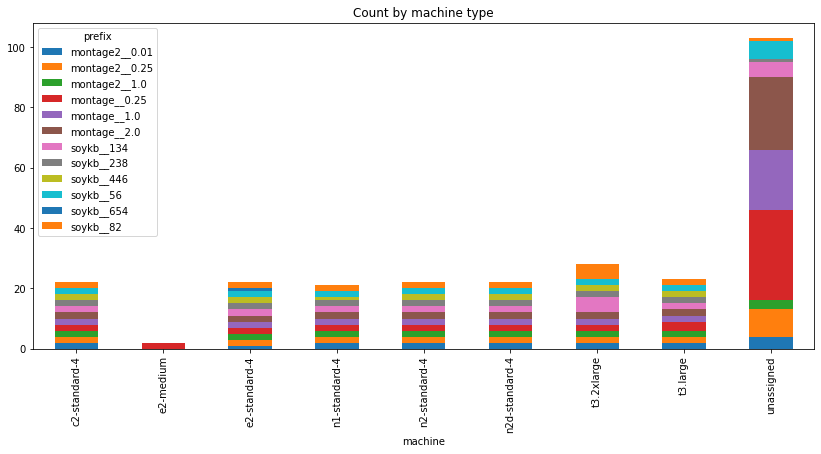

In [4]:
start_time = time.time()
LOGS_DIR_ROOT = "/data/"
workflow_prefix_regex = re.compile(r"(?P<name>\w+)__(?P<size>[0-9]+([,.][0-9]+)?)__")
workflow_prefix_dict = {}
machine_instances_dict = {}
workflows_df = pd.DataFrame(columns=["path", "machine", "prefix", "name", "size"])

for root, dirs, files in os.walk(LOGS_DIR_ROOT):
    if all(elem in files for elem in ["metrics.jsonl", "sys_info.jsonl", "job_descriptions.jsonl"]):
        match = workflow_prefix_regex.match(os.path.basename(root))
        if match:
            wf_name = match.group("name")
            wf_size = match.group("size")
            wf_prefix = f"{wf_name}__{wf_size}"
            workflow_prefix_dict.setdefault(wf_prefix, 0)
            workflow_prefix_dict[wf_prefix] += 1

            instance_type = os.path.basename(os.path.dirname(root))
            machine_instances_dict.setdefault(instance_type, {})
            machine_instances_dict[instance_type].setdefault(wf_prefix, 0)
            machine_instances_dict[instance_type][wf_prefix] += 1

            workflows_df = workflows_df.append({"path": root, "machine": instance_type, "prefix": wf_prefix, "name": wf_name, "size": wf_size}, ignore_index=True)

# print_full(workflows_df.groupby(["machine", "prefix"]).size().reset_index(name="count"))
print(f"All workflows: {len(workflows_df.index)}")
workflows_df.groupby(["machine", "prefix"]).size().unstack().plot(kind='bar',stacked=True, figsize=(14,6), title="Count by machine type")
plt.show()


## Select data
Available workflows types:
 - Montage: 
   - "montage__0.25", 
   - "montage__1.0", 
   - "montage__2.0",
 - Montage vol. 2: 
   - "montage2__0.01", 
   - "montage2__0.25", 
   - "montage2__1.0",
 - SoyKB: 
   - "soykb__56", 
   - "soykb__82", 
   - "soykb__134", 
   - "soykb__238", 
   - "soykb__446", 
   - "soykb__654" -->  not used since workflow was taking too long ~ 12h to finish

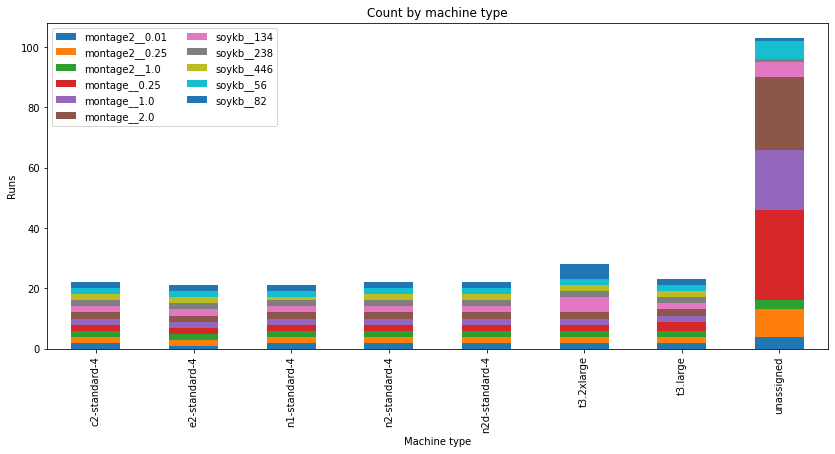

In [5]:

# drop unwanted cases
selected_df = workflows_df[
    # (workflows_df.machine != "unassigned") & 
    (workflows_df.machine != "e2-medium") &
    (workflows_df.prefix != "soykb__654") 
]
# selected_df = workflows_df
ax = selected_df.groupby(["machine", "prefix"]).size().unstack().plot(kind='bar',stacked=True, figsize=(14,6), title="Count by machine type")
ax.set_xlabel("Machine type")
ax.set_ylabel("Runs")
plt.legend(ncol=2)

## Nodes info

In [6]:
import sys
nodes = []
for path in selected_df.path:
    node_json = path + '/nodes_description.json'
    if os.path.isfile(node_json):
        # print(node_json)
        with open(node_json) as f_obj:
            instance = json.load(f_obj)
            count = len(instance["items"])
            nodes.append(count)
all_nodes_df = pd.DataFrame(nodes)
all_nodes_df.describe()

,0
count,144.000000
mean,4.416667
std,0.888937
min,3.000000
25%,4.000000
50%,4.000000
75%,5.000000
max,6.000000


## Load selected data

In [7]:
all_runs = []
for path in selected_df.path:
    print(path)
    df = load_and_merge_single_workflow_run(path)
    all_runs.append(df)

data = pd.concat(all_runs).reset_index(drop=True)

/data/aws/t3.2xlarge/soykb__82__1.0.0__2020-05-28-01-40-55
Length of metrics df = 7414
Rows with Nan values:	1
All rows:		82
/data/aws/t3.2xlarge/soykb__134__1.0.0__2020-05-28-07-58-11
Length of metrics df = 13415
Rows with Nan values:	1
All rows:		134
/data/aws/t3.2xlarge/soykb__238__1.0.0__2020-06-21-21-35-26
Length of metrics df = 31631
Rows with Nan values:	1
All rows:		238
/data/aws/t3.2xlarge/montage__0.25__1.0.0__2020-06-20-18-53-52
Length of metrics df = 52
Rows with Nan values:	0
All rows:		43
/data/aws/t3.2xlarge/soykb__238__1.0.0__2020-06-21-03-17-40
Length of metrics df = 31889
Rows with Nan values:	1
All rows:		238
/data/aws/t3.2xlarge/soykb__446__1.0.0__2020-06-21-12-49-17
Length of metrics df = 62790
Rows with Nan values:	1
All rows:		446
/data/aws/t3.2xlarge/soykb__82__1.0.0__2020-05-27-22-51-27
Length of metrics df = 7315
Rows with Nan values:	1
All rows:		82
/data/aws/t3.2xlarge/soykb__134__1.0.0__2020-05-28-12-49-33
Length of metrics df = 13444
Rows with Nan values:	

## Prepare data
- drop redundant columns
- drop <font color='red'>cpu</font>,  <font color='red'>memory</font>,  <font color='red'>network</font> and  <font color='red'>io</font> used, as we can't know these values while predicting


### Drop unique and empty columns

In [8]:
# drop empty columns and columns with only one unique value
data_dropped_redundant = data.dropna(axis='columns').reset_index(drop=True)
for col in data_dropped_redundant.columns:
    if len(data_dropped_redundant[col].unique()) == 1:
        data_dropped_redundant.drop(col,inplace=True,axis=1)

# print correlation matrix
# plt.figure(figsize=(30,30))
# sns.heatmap(data_dropped_redundant.corr().abs(), annot=True, cmap=plt.cm.Reds)

### Drop redundant columns

In [9]:
data_reduced = data_dropped_redundant.drop(
    errors='ignore',
    columns=["network.rxPackets", "network.txPackets",        # redundant because of tx and rx Bytes
                "io.writeCancelled", "io.writeReal",             # redundant because writeCancelled does not correlate with anything 
                                                                # and writeReal correlates exactly with io.write
                "mem_cached", "mem_buffcache", "mem_available",  # redundant because correlates exactly with mem_used and mem_total
                "ctime",                                         # redundant because correlates exactly with execTimeMs
                # EXPERIMENTAL DROPPING
                "io.readReal", "io.readSyscalls", "io.writeSyscalls", "network.txBytes", "mem_free", "mem_used", "mem_slab", "mem_buffers",
                "network.rxBytes"
    ])

### Job type count 

name
mDiffFit                  109542
mBackground                28598
mProjectPP                 15516
mProject                   15294
haplotype_caller            9260
genotype_gvcfs              1700
sort_sam                     471
alignment_to_reference       471
dedup                        469
add_replace                  464
realign_target_creator       463
indel_realign                463
mAdd                         288
mBgModel                     286
mConcatFit                   286
mImgtbl                      276
mViewer                      226
mShrink                      117
mJPEG                        117
faidx                         89
seq_dict                      88
bwa-index                     87
filtering_snp                 85
filtering_indel               85
select_variants_indel         85
combine_variants              85
select_variants_snp           85
merge_gcvf                    83
dtype: int64

Text(0, 0.5, 'Job type')

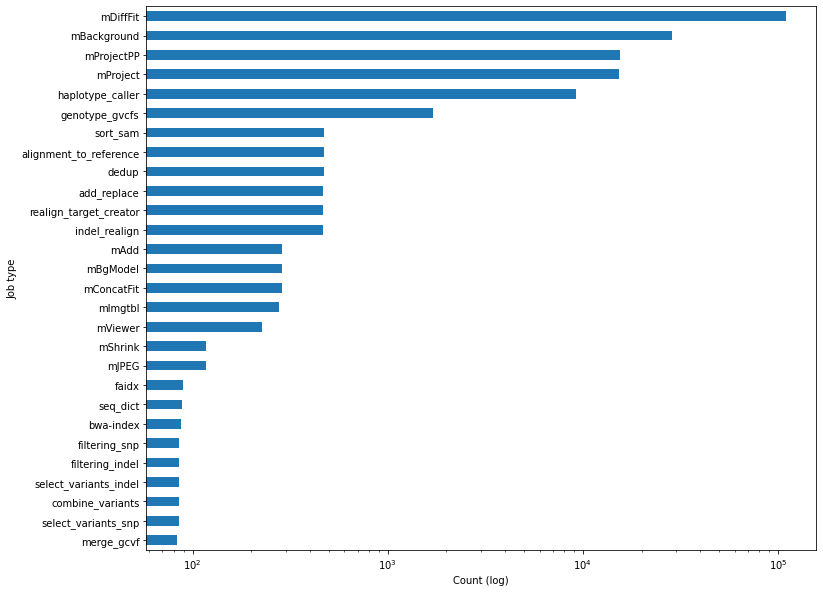

In [10]:
print_full(data_reduced.groupby("name").size().sort_values(ascending=False))
sortedJobOccurrence = data_reduced.groupby("name").size().sort_values()
ax = sortedJobOccurrence.plot(figsize=(12,10), kind="barh", logx=True )
ax.set_xlabel("Count (log)")
ax.set_ylabel("Job type")

### ExecTimeMs of job histogram

(1, 300000)

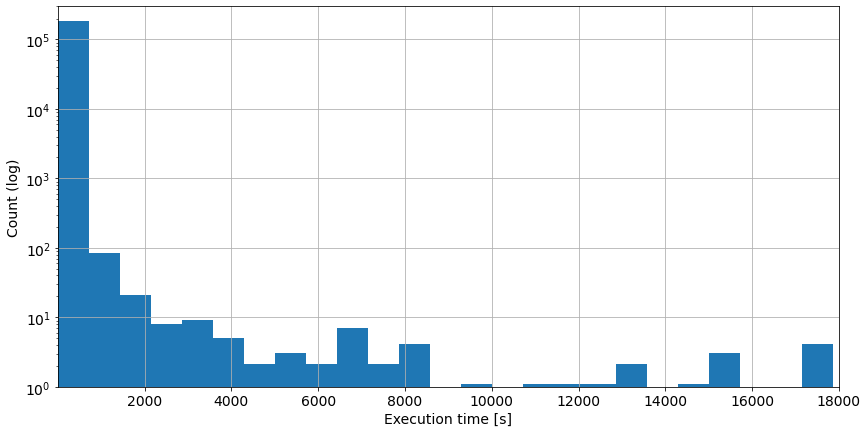

In [11]:
plt.rcParams.update({'font.size': 14})
execTimeInSec = data_reduced.execTimeMs.apply(lambda x: x/1000)
fig, ax = plt.subplots()
execTimeInSec.hist(figsize=(14,7), ax=ax, bins=50, bottom=0.1)
xticks = np.arange(execTimeInSec.min(), execTimeInSec.max(), 30)
x_range = (execTimeInSec.min(), (execTimeInSec.min() + 18000))
ax.ticklabel_format(useOffset=False, style='plain')
ax.set_yscale('log')
ax.set_ylabel("Count (log)")
ax.set_xlabel("Execution time [s]")
# ax.set_xticks(xticks)
ax.set_xlim(x_range)
ax.set_ylim((1, 300000))


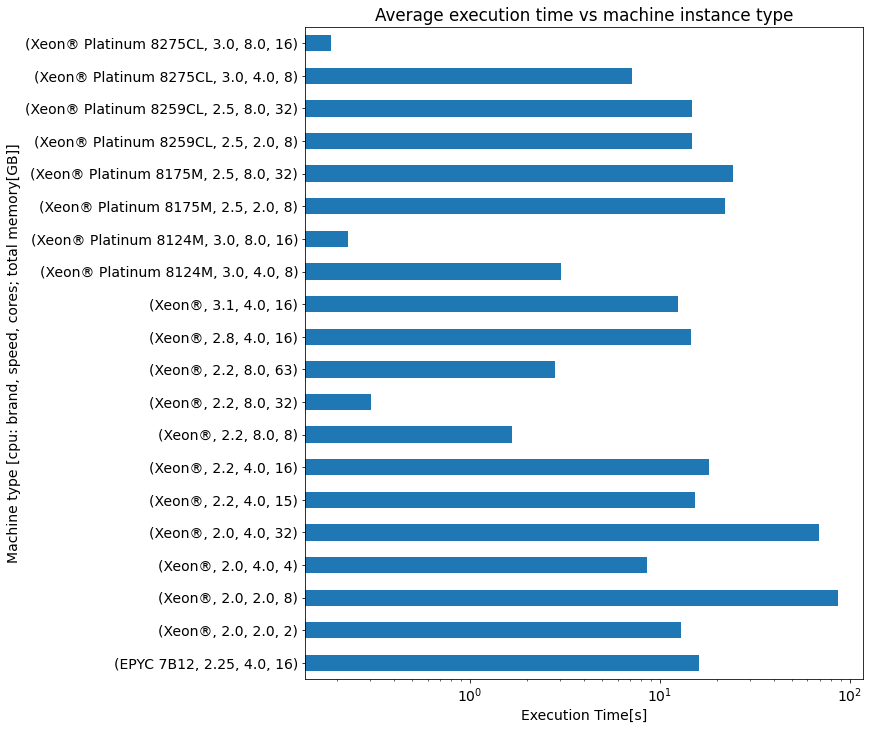

In [12]:
from math import floor, ceil
data_copy = data_reduced.copy()
data_copy.mem_total = data_reduced.mem_total.apply(lambda x: ceil(x/1024**3))
data_per_instance = data_copy.groupby(by=["cpu_brand", "cpu_speed", "cpu_cores", "mem_total"]).mean()
data_per_instance
data_per_instance_in_sec = data_per_instance.execTimeMs.apply(lambda x: x/1000)
ax = data_per_instance_in_sec.plot(kind="barh", figsize=(10,12), title="Average execution time vs machine instance type")
ax.set_xlabel("Execution Time[s]")
ax.set_ylabel("Machine type [cpu: brand, speed, cores; total memory[GB]]")
ax.set_xscale('log')
# ax.ticklabel_format(style='plain')

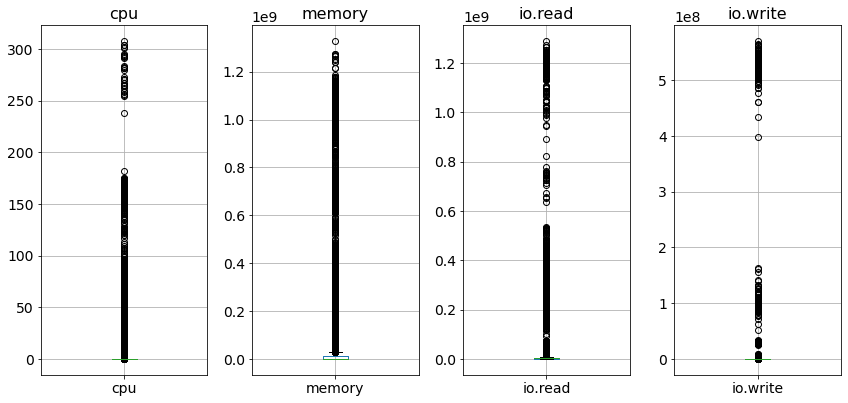

In [13]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(12,6))
elems = ["cpu", "memory", "io.read", "io.write"]

for idx, elem in enumerate(elems):
    ax = plt.subplot(1, 4, idx + 1)
    ax.set_title(elem , fontdict={"fontsize": 16})
    data_reduced.boxplot(column=elem)
fig.tight_layout(rect=[0, 0.03, 1, 1])

plt.show()

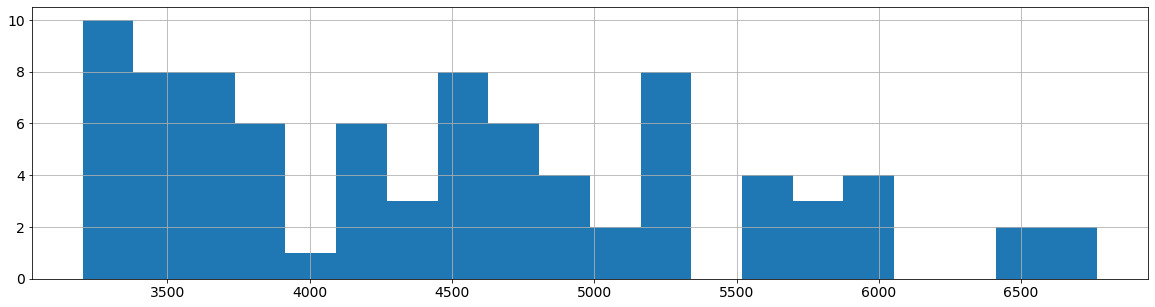

In [14]:
combine_variants = data_reduced[data_reduced["name"]=="combine_variants"]
# short = combine_variants[combine_variants.execTimeMs < 1200]
combine_variants.execTimeMs.hist(bins=20, figsize=(20,5))

### Distinguish various datasets 
- distribute the command instances evenly
- 4 datasets:
    - Evenly distributed data, containing all types of jobs, on all types of machines
    - Jobs of execution time lower than 1200 ms
    - Jobs with mediocre execution time, between 2000 ms and 25000 ms
    - Only most occurring jobs, with occurrence greater than 3000

In [15]:
# Dataset 1
data_reduced_dist = rep_sample(data_reduced, "name", data_reduced.name.nunique() * 100, replace=True)


# Dataset 4
# drop specific command types
filter_columns = [command for command in data_reduced.name.unique() if data_reduced.name[data_reduced.name == command].count() > 3000]
print(filter_columns)
data_reduced_v2 = data_reduced.query(f'name in {filter_columns}')
data_reduced_v2_dist = rep_sample(data_reduced_v2, "name", data_reduced_v2.name.nunique() * 6000, replace=True)

# Dataset 2
# filter by execTimeMs
data_short_execTime = data_reduced[data_reduced.execTimeMs < 3000]
data_short_execTime_dist = rep_sample(data_short_execTime, "name", data_short_execTime.name.nunique() * 120, replace=True)

# Dataset 3
data_medium_time = data_reduced[(data_reduced.execTimeMs > 4000) & (data_reduced.execTimeMs < 25000)]
data_medium_time_dist = rep_sample(data_medium_time, "name", data_medium_time.name.nunique() * 125, replace=True)

descriptions = {
    "Dataset 1": "Evenly distributed data, containing all types of jobs, on all types of machines",
    "Dataset 2": "Jobs of execution time lower than 3 s",
    "Dataset 3": "Jobs with mediocre execution time, between 4000 ms and 25000 ms",
    "Dataset 4": "Only most occurring jobs, with occurrence greater than 3000"
}

datasets = [
    ("Dataset 1", data_reduced_dist),  
    ("Dataset 2", data_short_execTime_dist),
    ("Dataset 3", data_medium_time_dist),
    ("Dataset 4", data_reduced_v2_dist),
]

datasets = OrderedDict(datasets)
datasets_orig = datasets.copy()
pd.set_option('display.float_format', lambda x: f'{x:,.2f}')
for key, value in datasets.copy().items():
    datasets[key] = pd.get_dummies(value)

    # print_full(datasets[key].describe().transpose())

['haplotype_caller', 'mProjectPP', 'mDiffFit', 'mBackground', 'mProject']


In [16]:
print_full(data_reduced_v2_dist.head(100))

,cpu,io.read,io.write,memory,cpu_manufacturer,cpu_brand,cpu_speed,cpu_cores,cpu_physicalCores,mem_total,mem_active,workflowName,size,inputs,outputs,name,execTimeMs
31296,50.53,"45,695,447.82","2,845.55","362,380,194.91",Intel®,Xeon® Platinum 8259CL,2.50,2.00,1.00,"8,257,200,128.00","831,979,520.00",soykb,446,11,2,haplotype_caller,"54,026.00"
148806,26.29,"39,720,691.92","1,758.74","350,130,383.39",Intel®,Xeon®,2.00,4.00,2.00,"33,736,265,728.00","2,328,027,136.00",soykb,238,11,2,haplotype_caller,"156,901.00"
31249,50.78,"39,197,484.38","1,142.73","307,204,437.33",Intel®,Xeon® Platinum 8259CL,2.50,2.00,1.00,"8,257,200,128.00","840,851,456.00",soykb,446,11,2,haplotype_caller,"46,883.00"
1177,50.35,"49,713,094.20","1,248.27","408,416,752.48",Intel®,Xeon® Platinum 8175M,2.50,8.00,4.00,"33,359,015,936.00","1,413,820,416.00",soykb,82,11,2,haplotype_caller,"65,483.00"
77415,53.95,"31,252,916.00","1,064.59","283,050,112.00",AMD,EPYC 7B12,2.25,4.00,2.00,"16,824,102,912.00","1,764,806,656.00",soykb,238,11,2,haplotype_caller,"31,341.00"
3285,52.68,"37,247,389.95","1,120.69","300,679,070.48",Intel®,Xeon® Platinum 8259CL,2.50,8.00,4.00,"33,359,015,936.00","2,059,309,056.00",soykb,56,11,2,haplotype_caller,"40,546.00"
188,51.13,"43,705,996.02","2,518.22","380,698,802.09",Intel®,Xeon® Platinum 8259CL,2.50,8.00,4.00,"33,359,015,936.00","1,368,248,320.00",soykb,134,11,2,haplotype_caller,"44,335.00"
3213,51.18,"43,280,732.15","1,162.20","370,800,907.13",Intel®,Xeon® Platinum 8175M,2.50,8.00,4.00,"33,359,015,936.00","1,484,685,312.00",soykb,134,11,2,haplotype_caller,"45,331.00"
17541,51.97,"43,582,618.64","1,147.60","349,014,507.52",Intel®,Xeon® Platinum 8259CL,2.50,2.00,1.00,"8,257,200,128.00","715,452,416.00",soykb,134,11,2,haplotype_caller,"49,805.00"
2343,51.90,"51,017,822.40","1,223.74","466,476,600.89",Intel®,Xeon® Platinum 8175M,2.50,8.00,4.00,"33,359,015,936.00","5,480,792,064.00",soykb,446,11,2,haplotype_caller,"70,609.00"


### Datasets stats

In [17]:
for dataset in datasets.values():
    print_full(dataset.describe())

,cpu,io.read,io.write,memory,cpu_speed,cpu_cores,cpu_physicalCores,mem_total,mem_active,inputs,outputs,execTimeMs,cpu_manufacturer_AMD,cpu_manufacturer_Intel®,cpu_brand_EPYC 7B12,cpu_brand_Xeon®,cpu_brand_Xeon® Platinum 8124M,cpu_brand_Xeon® Platinum 8175M,cpu_brand_Xeon® Platinum 8259CL,cpu_brand_Xeon® Platinum 8275CL,workflowName_montage,workflowName_montage2,workflowName_soykb,size_0.01,size_0.25,size_1.0,size_2.0,size_56.0,size_82.0,size_134.0,size_238.0,size_446.0,size_619.0,name_add_replace,name_alignment_to_reference,name_bwa-index,name_combine_variants,name_dedup,name_faidx,name_filtering_indel,name_filtering_snp,name_genotype_gvcfs,name_haplotype_caller,name_indel_realign,name_mAdd,name_mBackground,name_mBgModel,name_mConcatFit,name_mDiffFit,name_mImgtbl,name_mJPEG,name_mProject,name_mProjectPP,name_mShrink,name_mViewer,name_merge_gcvf,name_realign_target_creator,name_select_variants_indel,name_select_variants_snp,name_seq_dict,name_sort_sam
count,"2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00","2,800.00"
mean,30.95,"110,726,115.48","24,538,343.82","138,079,465.89",2.50,4.68,2.81,"17,474,414,319.91","1,382,736,149.94",37.63,1.66,"396,154.59",0.10,0.90,0.10,0.56,0.07,0.07,0.17,0.02,0.19,0.20,0.61,0.04,0.11,0.14,0.10,0.09,0.10,0.13,0.14,0.15,0.00,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04,0.04
std,33.55,"250,855,903.40","104,431,146.11","218,951,746.72",0.36,2.02,1.57,"9,338,204,560.86","757,438,601.71",131.62,0.81,"2,425,290.95",0.30,0.30,0.30,0.50,0.26,0.26,0.38,0.13,0.39,0.40,0.49,0.20,0.31,0.35,0.29,0.29,0.30,0.33,0.34,0.36,0.05,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19,0.19
min,0.00,"1,225.00",0.50,"4,096.00",2.00,2.00,1.00,"2,092,941,312.00","683,720,704.00",1.00,1.00,21.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,"69,838.00",1.00,"10,597,376.00",2.20,4.00,2.00,"8,369,483,776.00","1,068,381,184.00",2.00,1.00,623.75,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,30.63,"3,839,838.88",175.50,"52,316,160.00",2.50,4.00,2.00,"16,824,102,912.00","1,251,119,104.00",5.00,2.00,"4,084.00",0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,49.55,"66,279,342.74","2,541.06","170,142,429.27",2.80,4.00,4.00,"16,824,107,008.00","1,407,991,808.00",11.00,2.00,"31,011.00",0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,301.85,"1,289,187,359.57","570,527,589.57","1,176,659,968.00",3.10,8.00,8.00,"67,557,654,528.00","9,897,963,520.00","1,138.00",5.00,"35,7

,cpu,io.read,io.write,memory,cpu_speed,cpu_cores,cpu_physicalCores,mem_total,mem_active,inputs,outputs,execTimeMs,cpu_manufacturer_AMD,cpu_manufacturer_Intel®,cpu_brand_EPYC 7B12,cpu_brand_Xeon®,cpu_brand_Xeon® Platinum 8124M,cpu_brand_Xeon® Platinum 8175M,cpu_brand_Xeon® Platinum 8259CL,cpu_brand_Xeon® Platinum 8275CL,workflowName_montage,workflowName_montage2,workflowName_soykb,size_0.01,size_0.25,size_1.0,size_2.0,size_56.0,size_82.0,size_134.0,size_238.0,size_446.0,size_619.0,name_add_replace,name_alignment_to_reference,name_dedup,name_faidx,name_filtering_indel,name_filtering_snp,name_indel_realign,name_mAdd,name_mBackground,name_mBgModel,name_mConcatFit,name_mDiffFit,name_mImgtbl,name_mJPEG,name_mProjectPP,name_mShrink,name_mViewer,name_sort_sam
count,"2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00","2,160.00"
mean,10.55,"19,259,518.91","540,985.34","86,283,055.57",2.59,4.89,2.99,"16,191,275,666.01","1,244,756,819.44",16.21,1.52,"1,269.60",0.12,0.88,0.12,0.48,0.14,0.06,0.15,0.06,0.32,0.23,0.44,0.10,0.19,0.13,0.13,0.04,0.09,0.12,0.07,0.12,0.00,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06,0.06
std,16.66,"65,226,830.38","7,373,255.51","257,471,019.09",0.38,2.06,1.60,"8,902,998,565.58","611,749,740.93",45.22,0.50,"1,092.24",0.33,0.33,0.33,0.50,0.35,0.23,0.35,0.23,0.47,0.42,0.50,0.30,0.40,0.34,0.34,0.20,0.29,0.33,0.26,0.32,0.07,0.23,0.23,0.23,0.23,0.23,0.23,0.23,0.23,0.23,0.23,0.23,0.23,0.23,0.23,0.23,0.23,0.23,0.23
min,0.00,"1,225.00",0.50,0.00,2.00,2.00,1.00,"2,092,941,312.00","661,868,544.00",1.00,1.00,18.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,"2,249.00",1.00,"2,447,360.00",2.20,4.00,2.00,"8,368,402,432.00","1,028,993,024.00",2.00,1.00,384.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,"163,721.00",1.00,"11,304,960.00",2.50,4.00,2.00,"16,824,086,528.00","1,165,463,552.00",3.00,2.00,703.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,24.50,"3,938,660.19",317.31,"47,206,400.00",3.00,8.00,4.00,"16,824,107,008.00","1,340,653,568.00",10.00,2.00,"2,592.00",0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,48.76,"436,950,824.00","103,512,961.00","1,130,788,864.00",3.10,8.00,8.00,"67,557,654,528.00","8,834,732,032.00",308.00,2.00,"2,996.00",1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


,cpu,io.read,io.write,memory,cpu_speed,cpu_cores,cpu_physicalCores,mem_total,mem_active,inputs,outputs,execTimeMs,cpu_manufacturer_AMD,cpu_manufacturer_Intel®,cpu_brand_EPYC 7B12,cpu_brand_Xeon®,cpu_brand_Xeon® Platinum 8124M,cpu_brand_Xeon® Platinum 8175M,cpu_brand_Xeon® Platinum 8259CL,cpu_brand_Xeon® Platinum 8275CL,workflowName_montage,workflowName_montage2,workflowName_soykb,size_0.01,size_0.25,size_1.0,size_2.0,size_56.0,size_82.0,size_134.0,size_238.0,size_446.0,size_619.0,name_alignment_to_reference,name_combine_variants,name_dedup,name_faidx,name_filtering_indel,name_filtering_snp,name_genotype_gvcfs,name_indel_realign,name_mAdd,name_mBackground,name_mBgModel,name_mConcatFit,name_mDiffFit,name_mImgtbl,name_mProject,name_mProjectPP,name_mShrink,name_mViewer,name_select_variants_indel,name_select_variants_snp,name_seq_dict
count,"2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00","2,625.00"
mean,38.43,"93,842,629.54","14,877,041.15","118,477,014.37",2.38,4.50,2.85,"15,507,638,870.41","1,404,481,436.14",76.49,1.48,"11,023.34",0.10,0.90,0.10,0.59,0.07,0.04,0.20,0.01,0.19,0.29,0.52,0.00,0.05,0.25,0.16,0.16,0.06,0.13,0.08,0.09,0.00,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
std,24.55,"182,868,376.15","70,414,207.59","219,453,398.87",0.33,2.00,1.53,"10,428,075,136.20","724,205,857.90",207.12,0.50,"7,092.87",0.30,0.30,0.30,0.49,0.25,0.19,0.40,0.08,0.39,0.45,0.50,0.06,0.22,0.44,0.37,0.37,0.23,0.34,0.28,0.29,0.05,0.21,0.21,0.21,0.21,0.21,0.21,0.21,0.21,0.21,0.21,0.21,0.21,0.21,0.21,0.21,0.21,0.21,0.21,0.21,0.21,0.21
min,0.00,"1,225.00",0.60,"4,096.00",2.00,2.00,1.00,"2,092,941,312.00","695,795,712.00",1.00,1.00,"4,002.00",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,14.13,"2,140,649.67",21.00,"9,495,040.00",2.20,4.00,2.00,"8,257,200,128.00","1,140,264,960.00",2.00,1.00,"4,924.00",0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,40.32,"5,129,140.67","4,106.12","56,943,274.67",2.25,4.00,2.00,"15,767,138,304.00","1,322,913,792.00",10.00,1.00,"7,698.00",0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,55.97,"93,604,889.00","1,173,395.29","107,298,816.00",2.50,4.00,4.00,"16,824,102,912.00","1,476,685,824.00",11.00,2.00,"18,039.00",0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,90.73,"1,141,454,515.71","563,686,355.29","1,328,420,864.00",3.10,8.00,8.00,"67,557,654,528.00","9,659,494,400.00","1,138.00",2.00,"24,982.00",1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


,cpu,io.read,io.write,memory,cpu_speed,cpu_cores,cpu_physicalCores,mem_total,mem_active,inputs,outputs,execTimeMs,cpu_manufacturer_AMD,cpu_manufacturer_Intel®,cpu_brand_EPYC 7B12,cpu_brand_Xeon®,cpu_brand_Xeon® Platinum 8124M,cpu_brand_Xeon® Platinum 8175M,cpu_brand_Xeon® Platinum 8259CL,cpu_brand_Xeon® Platinum 8275CL,workflowName_montage,workflowName_montage2,workflowName_soykb,size_0.01,size_0.25,size_1.0,size_2.0,size_56.0,size_82.0,size_134.0,size_238.0,size_446.0,size_619.0,name_haplotype_caller,name_mBackground,name_mDiffFit,name_mProject,name_mProjectPP
count,"30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00","30,000.00"
mean,24.83,"9,503,156.81","75,616.06","77,496,270.93",2.50,5.01,3.43,"16,949,292,967.12","1,437,864,863.61",4.96,1.88,"16,671.00",0.09,0.91,0.09,0.57,0.10,0.07,0.13,0.04,0.39,0.41,0.20,0.00,0.07,0.43,0.29,0.01,0.01,0.03,0.05,0.09,0.00,0.20,0.20,0.20,0.20,0.20
std,31.47,"16,317,366.40","431,454.80","141,589,866.67",0.36,2.14,1.72,"10,626,573,361.13","706,114,928.39",3.36,0.33,"24,286.40",0.29,0.29,0.29,0.50,0.30,0.25,0.33,0.20,0.49,0.49,0.40,0.04,0.26,0.50,0.46,0.09,0.12,0.18,0.22,0.29,0.05,0.40,0.40,0.40,0.40,0.40
min,0.00,612.50,0.33,0.00,2.00,2.00,1.00,"2,092,941,312.00","676,913,152.00",2.00,1.00,34.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
25%,0.00,"2,250.00",1.00,"1,903,616.00",2.20,4.00,2.00,"8,368,402,432.00","1,152,092,160.00",2.00,2.00,356.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
50%,0.00,"2,447,592.68",1.00,"11,087,286.86",2.50,4.00,4.00,"16,824,090,624.00","1,322,670,080.00",4.00,2.00,930.00,0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
75%,52.71,"4,200,850.00","1,097.00","15,265,792.00",2.80,8.00,4.00,"16,824,102,912.00","1,476,273,152.00",7.00,2.00,"27,833.00",0.00,1.00,0.00,1.00,0.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,1.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
max,90.77,"51,693,614.19","6,626,315.20","472,730,112.00",3.10,8.00,8.00,"67,557,654,528.00","9,887,666,176.00",11.00,2.00,"219,758.00",1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00,1.00


In [18]:
test = pd.DataFrame([1,2,3,4,5,6,7,8,9,10])
test.describe()
# test.quantile(0.25)

,0
count,10.00
mean,5.50
std,3.03
min,1.00
25%,3.25
50%,5.50
75%,7.75
max,10.00


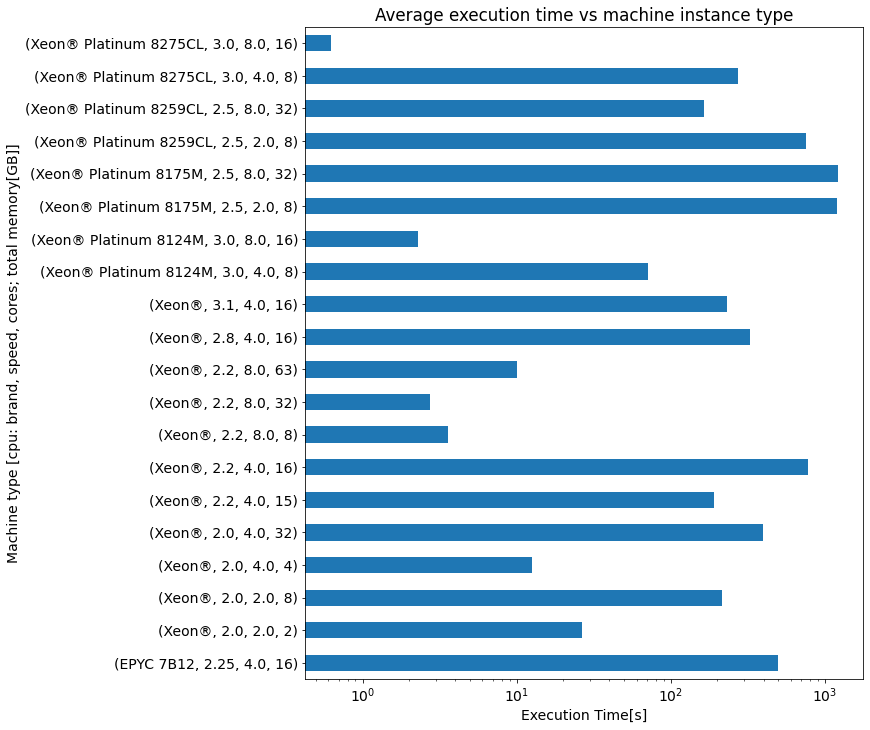

In [19]:
from math import floor, ceil
data_copy = data_reduced_dist.copy()
data_copy.mem_total = data_reduced_dist.mem_total.apply(lambda x: ceil(x/1024**3))
data_per_instance = data_copy.groupby(by=["cpu_brand", "cpu_speed", "cpu_cores", "mem_total"]).mean()
data_per_instance
data_per_instance_in_sec = data_per_instance.execTimeMs.apply(lambda x: x/1000)
ax = data_per_instance_in_sec.plot(kind="barh", figsize=(10,12), title="Average execution time vs machine instance type")
ax.set_xlabel("Execution Time[s]")
ax.set_ylabel("Machine type [cpu: brand, speed, cores; total memory[GB]]")
ax.set_xscale('log')
# ax.ticklabel_format(style='plain')

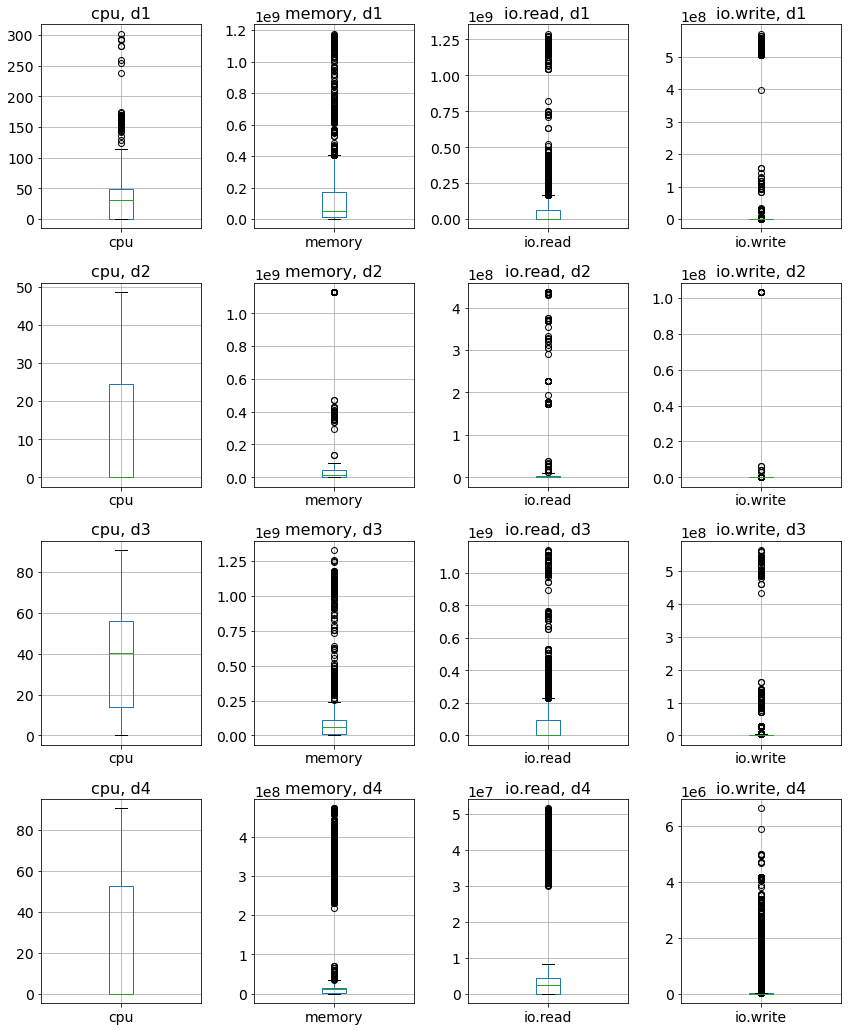

In [20]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(12,15))
elems = ["cpu", "memory", "io.read", "io.write"]

idx = 0
for desc, data in datasets.copy().items():
    for elem in elems:
        idx = idx + 1
        ax = plt.subplot(4, 4, idx)
        ax.set_title(elem + ", " + "d"+ desc[-1], fontdict={"fontsize": 16})
        data.boxplot(column=elem)
fig.tight_layout(rect=[0, 0.03, 1, 1])

plt.show()

### Histogram of job type in all datasets

Text(0, 0.5, 'Job type')

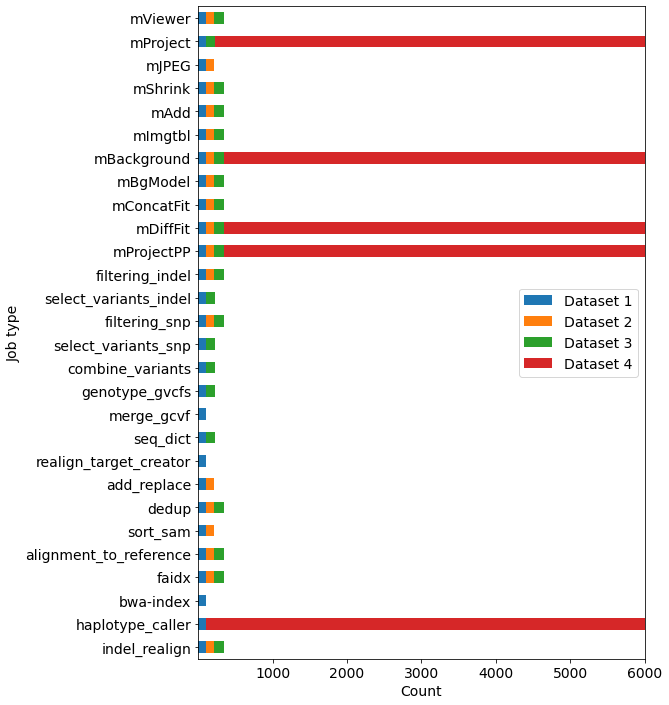

In [21]:
plt.rcParams.update({'font.size': 14})
countDf = pd.DataFrame(index=data_reduced.name.unique())
for idx, (desc, data) in enumerate(datasets_orig.copy().items()):
    temp = data.groupby(['name']).size()
    countDf = pd.concat([countDf, temp], axis=1, names=["dataset", "ad"])
countDf.columns = ["Dataset 1", "Dataset 2", "Dataset 3", "Dataset 4"]
# print_full(countDf)
ax = countDf.plot(kind="barh", stacked=True, figsize=(8,12))
# ax.set_xscale('log')
ax.set_xlim((1, 6000))
# ax.set_ylim((1, 300000))
ax.set_xlabel("Count")
ax.set_ylabel("Job type")

### Histogram of execTimeMs of all datasets

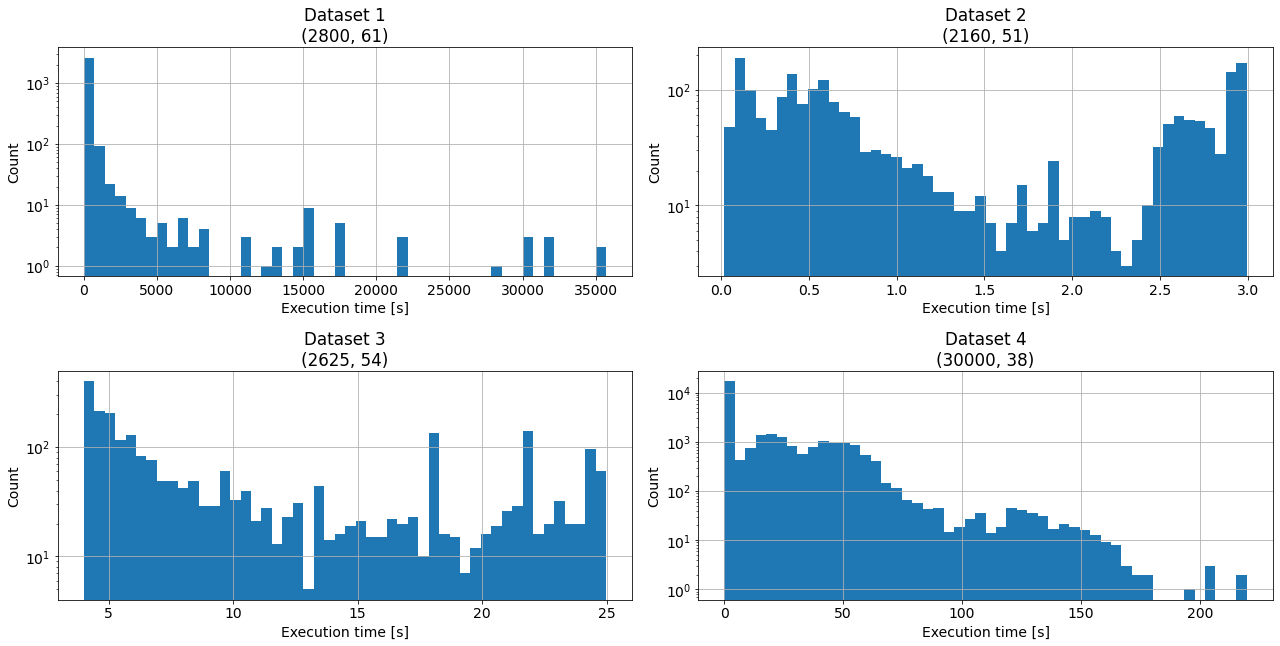

In [22]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(18,10))
for idx, (desc, data) in enumerate(datasets.copy().items()):
    ax = plt.subplot(2, 2, idx + 1)
    ax.ticklabel_format(useOffset=False, style='plain')
    ax.set_title(desc + "\n" +  str(data.shape))
    ax.set_yscale('log')

    ax.set_xlabel("Execution time [s]")
    ax.set_ylabel("Count")
    data_in_sec = pd.DataFrame(data)
    data_in_sec.execTimeMs = data.execTimeMs.apply(lambda x: x/1000)
    data_in_sec.execTimeMs.hist(bins=50)

fig.tight_layout(rect=[0, 0.03, 1, 0.95])

plt.show()

### Helper functions for data preparation

In [23]:
# Classify data based on intensivity (threshold = mean value)
def classify_intensivity(data_encoded): 
    cpu_mean = data_encoded.cpu.mean()
    mem_mean = data_encoded.memory.mean()
    # net_mean = data_encoded["network.rxBytes"].mean()
    io_read_mean = data_encoded["io.read"].mean()
    io_write_mean = data_encoded["io.write"].mean()

    data_temp = data_encoded.reset_index(drop=True)
    data_temp["cpu_intensive"] = data_temp.cpu.apply(lambda x: 1 if x > cpu_mean else 0)
    data_temp["memory_intensive"] = data_temp.memory.apply(lambda x: 1 if x > mem_mean else 0)
    # data_temp["network_intensive"] = data_temp["network.rxBytes"].apply(lambda x: 1 if x > net_mean else 0)
    data_temp["io.read_intensive"] = data_temp["io.read"].apply(lambda x: 1 if x > io_read_mean else 0)
    data_temp["io.write_intensive"] = data_temp["io.write"].apply(lambda x: 1 if x > io_write_mean else 0)
    # data_temp.drop(inplace=True, columns=["cpu", "memory", "network.rxBytes", "io.read", "io.write"])
    data_temp.drop(inplace=True, columns=["cpu", "memory", "io.read", "io.write"])
    # print_full(data_temp.describe().transpose())
    # plt.figure(figsize=(60,50))
    # sns.heatmap(data_temp.corr().abs(), annot=True, cmap=plt.cm.Reds)
    return data_temp

In [24]:
# Classify data based on intensivity (threshold = mean value)
def classify_intensivity_mean(data_encoded): 
    data_temp = data_encoded.reset_index(drop=True)
    data_temp["cpu_intensive"] = data_temp["cpu"]
    data_temp["memory_intensive"] = data_temp["memory"]
    # data_temp["network_intensive"] = data_temp["network.rxBytes"].apply(lambda x: 1 if x > net_mean else 0)
    data_temp["io.read_intensive"] = data_temp["io.read"]
    data_temp["io.write_intensive"] = data_temp["io.write"]
    # data_temp.drop(inplace=True, columns=["cpu", "memory", "network.rxBytes", "io.read", "io.write"])
    data_temp.drop(inplace=True, columns=["cpu", "memory", "io.read", "io.write"])
    return data_temp

In [25]:
# Classify data based on intensivity by quartiles(threshold = mean value)
def classify_intensivity_by_quartiles(data_encoded): 

    cpu_25 = data_encoded.cpu.quantile(0.25)
    cpu_50 = data_encoded.cpu.quantile(0.50)
    cpu_75 = data_encoded.cpu.quantile(0.75)

    mem_25 = data_encoded.memory.quantile(0.25)
    mem_50 = data_encoded.memory.quantile(0.50)
    mem_75 = data_encoded.memory.quantile(0.75)

    read_25 = data_encoded["io.read"].quantile(0.25)
    read_50 = data_encoded["io.read"].quantile(0.50)
    read_75 = data_encoded["io.read"].quantile(0.75)

    write_25 = data_encoded["io.write"].quantile(0.25)
    write_50 = data_encoded["io.write"].quantile(0.50)
    write_75 = data_encoded["io.write"].quantile(0.75)

    data_temp = data_encoded.reset_index(drop=True)
    data_temp["cpu_intensive"] = data_temp.cpu.apply(lambda x: 0 if x < cpu_25 else 1 if x > cpu_25 and x < cpu_50 else 2 if x > cpu_50 and x < cpu_75 else 3)
    data_temp["memory_intensive"] = data_temp.memory.apply(lambda x: 0 if x < mem_25 else 1 if x > mem_25 and x < mem_50 else 2 if x > mem_50 and x < mem_75 else 3)
    data_temp["io.read_intensive"] = data_temp["io.read"].apply(lambda x: 0 if x < read_25 else 1 if x > read_25 and x < read_50 else 2 if x > read_50 and x < read_75 else 3)
    data_temp["io.write_intensive"] = data_temp["io.write"].apply(lambda x: 0 if x < write_25 else 1 if x > write_25 and x < write_50 else 2 if x > write_50 and x < write_75 else 3)
    data_temp.drop(inplace=True, columns=["cpu", "memory", "io.read", "io.write"])
    # print_full(data_temp.head(30))
    return data_temp

In [26]:
def separate_features_labels(data_temp):
    data_final = data_temp.reset_index(drop=True)

    labels_exec_time = data_final.pop("execTimeMs")
    # labels_classify  = data_final[["cpu_intensive", "memory_intensive", "network_intensive", "io.read_intensive", "io.write_intensive"]].copy()
    labels_classify  = data_final[["cpu_intensive", "memory_intensive", "io.read_intensive", "io.write_intensive"]].copy()

    # features = data_final.drop(["cpu_intensive", "memory_intensive", "network_intensive", "io.read_intensive", "io.write_intensive"], axis=1)
    features = data_final.drop(["cpu_intensive", "memory_intensive", "io.read_intensive", "io.write_intensive"], axis=1)

    return {"data": data_final, "features": features, "labels_classify": labels_classify, "labels_exec_time": labels_exec_time}

In [27]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support

def model_LR(features, labels, label_to_predict):
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels[label_to_predict], test_size=0.25, random_state = 0)

    # Feature scaling with MinMaxScaler
    scale_features_mm = MinMaxScaler()
    features_train = scale_features_mm.fit_transform(features_train)
    features_test = scale_features_mm.transform(features_test)

    clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='ovr', max_iter=1000).fit(features_train, labels_train)
    score = clf.score(features_test, labels_test)
    

    F1 = f1_score(labels_test, clf.predict(features_test))
    print(f"{label_to_predict.upper()} prediction:\nscore = {score}\nF1 = {F1}\n")
    print(confusion_matrix(labels_test, clf.predict(features_test)))
    print(precision_recall_fscore_support(labels_test, clf.predict(features_test)))
    return clf

In [28]:
def apply_classifiers(features, labels_classify):
    classifiers = {}
    for label in labels_classify.columns:
        # if label == "cpu_intensive":
        #     continue
        try:
            classifiers[label] = model_LR(features, labels_classify, label)
        except:  
            print(f"Exception!!!!!")
            continue 
    return classifiers

In [29]:
def split_and_scale(features, labels):
    features_train, features_test, labels_train, labels_test = train_test_split(features, labels, test_size=0.25, random_state = 0)

    # Feature scaling with MinMaxScaler
    scale_features_mm = MinMaxScaler()
    scale_labels_mm = MinMaxScaler()

    features_train = scale_features_mm.fit_transform(features_train)
    features_test = scale_features_mm.transform(features_test)

    # scale_labels_mm.fit(labels_exec_time.values.reshape(-1,1))
    # labels_train = scale_labels_mm.transform(labels_train.values.reshape(-1,1))
    # labels_test = scale_labels_mm.transform(labels_test.values.reshape(-1,1))
    return (features_train, features_test, labels_train, labels_test)



### Histogram of classified intensity per dataset

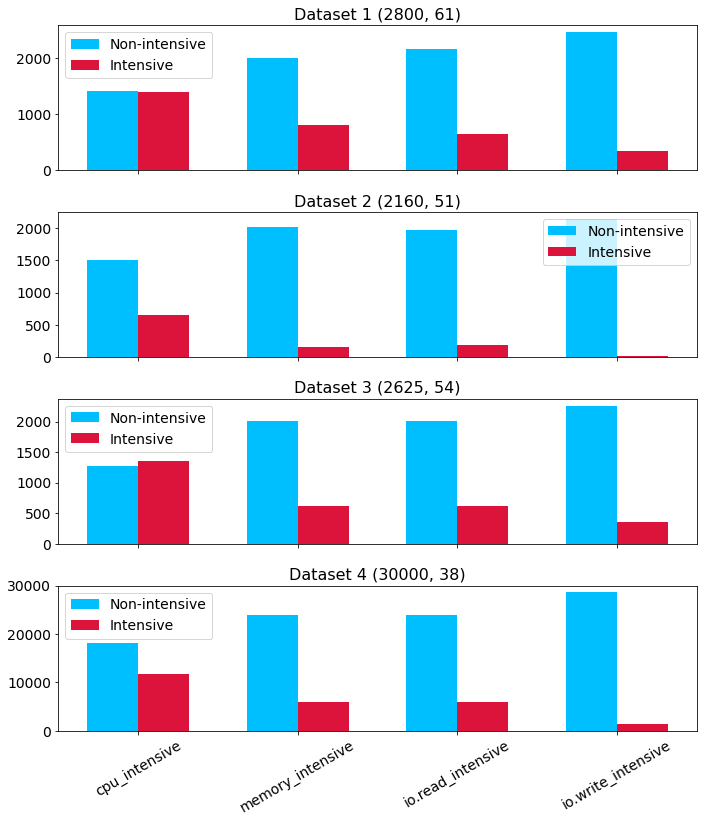

In [30]:
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(10,12))
# elems = ["cpu_intensive", "memory_intensive", "network_intensive", "io.read_intensive", "io.write_intensive"]
elems = ["cpu_intensive", "memory_intensive", "io.read_intensive", "io.write_intensive"]

x = np.arange(len(elems))
width = 0.32  # the width of the bars

for idx, (desc, data) in enumerate(datasets.copy().items()):
    ax = plt.subplot(4, 1, idx + 1)
    ax.set_title(desc + " " + str(data.shape), fontdict={"fontsize": 16})
    ones = []
    zeros = []
    for elem in elems:
        count, division = np.histogram(classify_intensivity(data)[elem], bins=2)
        zeros.append(count[0])
        ones.append(count[1])
    ax.bar(x - width/2, zeros, width, label="Non-intensive", color="deepskyblue")
    ax.bar(x + width/2, ones, width, label="Intensive", color="crimson")
    
    ax.set_xticks(x)
    ax.set_xticklabels(elems)
    
    ax.legend()
    if (idx == 3):
        ax.tick_params(labelbottom=True)
    else:
        ax.tick_params(labelbottom=False)
    plt.xticks(rotation=30)
fig.tight_layout(rect=[0, 0.03, 1, 1])

plt.show()

## Label parameters by intensivity

In [31]:
datasets_prepared = OrderedDict()
for key, data in datasets.copy().items():
    temp = classify_intensivity(data)
    # temp = classify_intensivity_mean(data)
    # temp = classify_intensivity_by_quartiles(data)
    
    data_dict = separate_features_labels(temp)
    # apply_classifiers(data_dict["features"], data_dict["labels_classify"])
    # {"data": data_final, "features": features, "labels_classify": labels_classify, "labels_exec_time": labels_exec_time}
    data_dict["split"] = split_and_scale(data_dict["data"], data_dict["labels_exec_time"])
    datasets_prepared[key] = data_dict

## PCA & t-SNE dimention reduction - projection to 2D

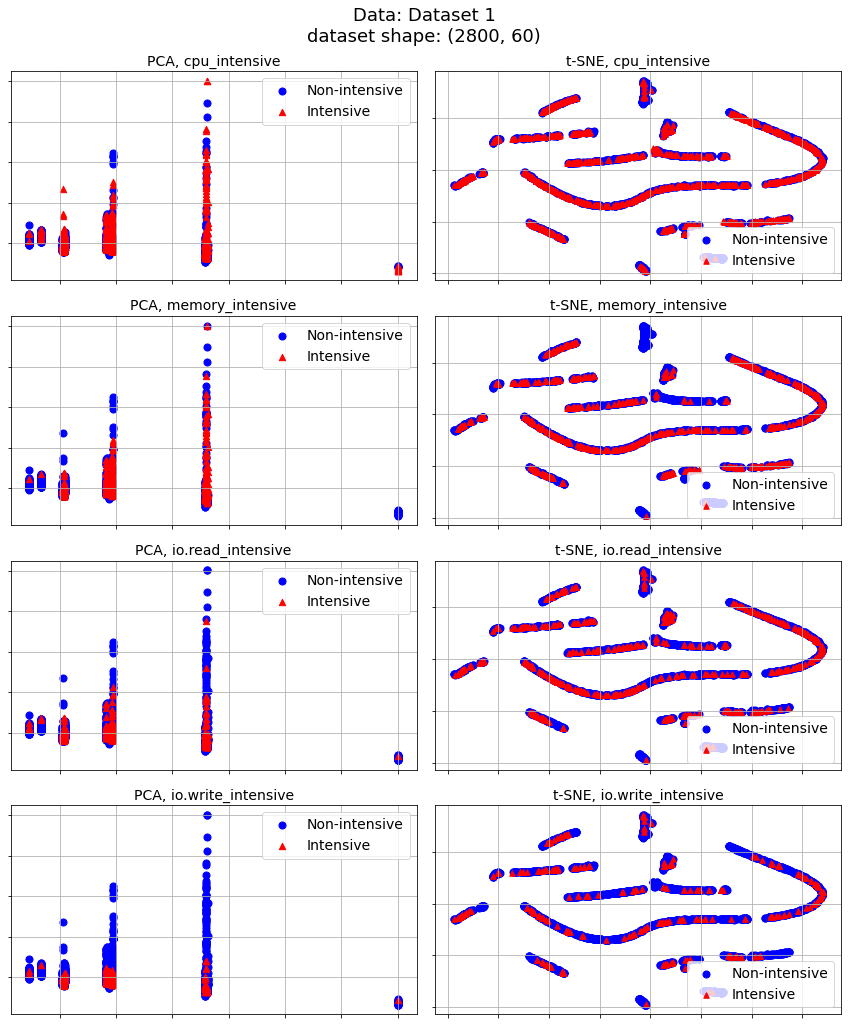

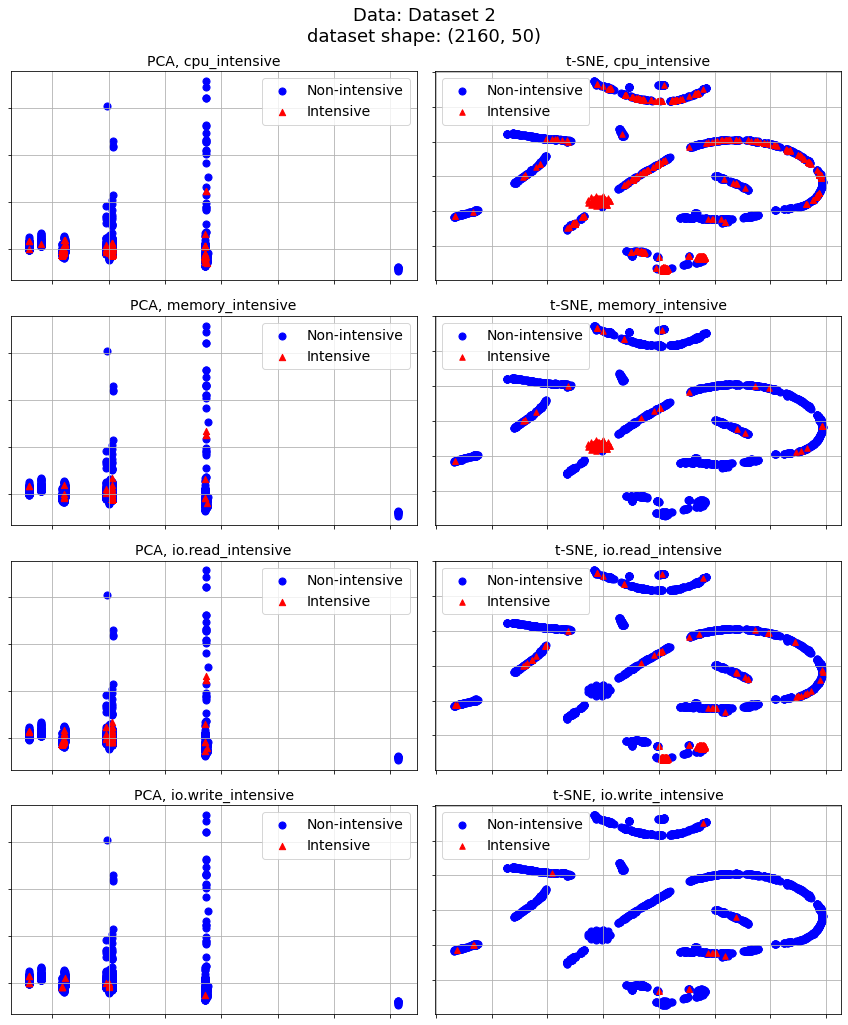

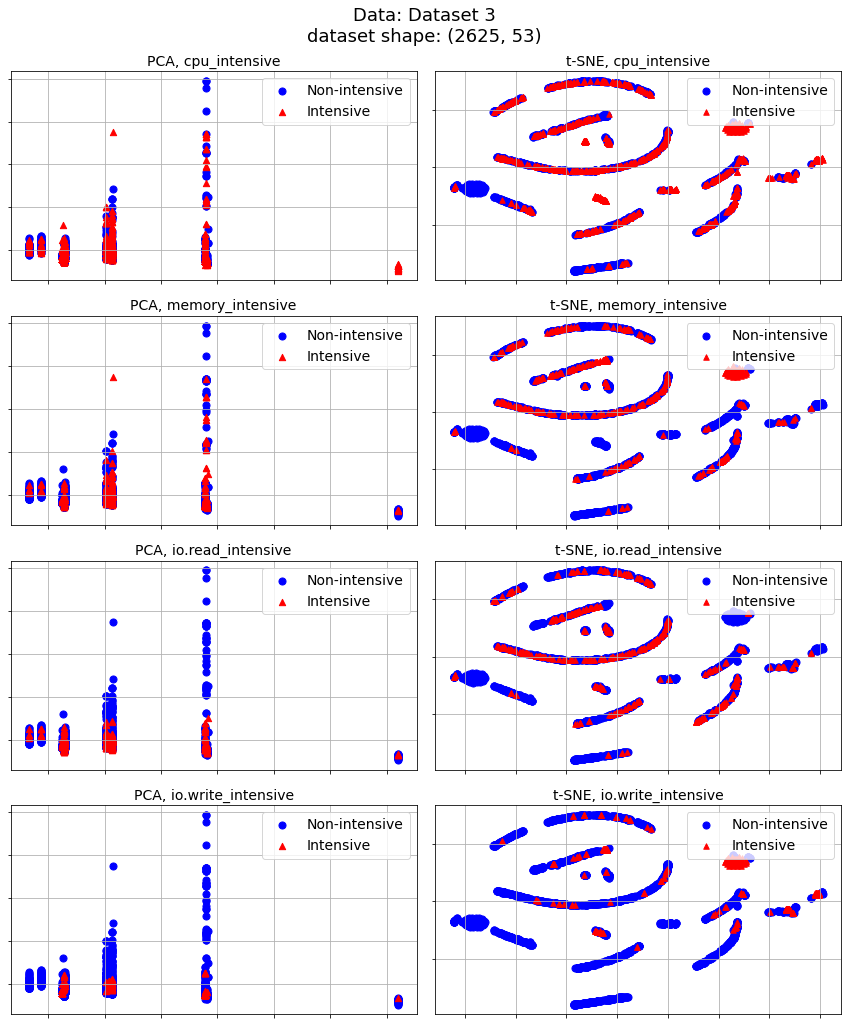

KeyboardInterrupt: ignored

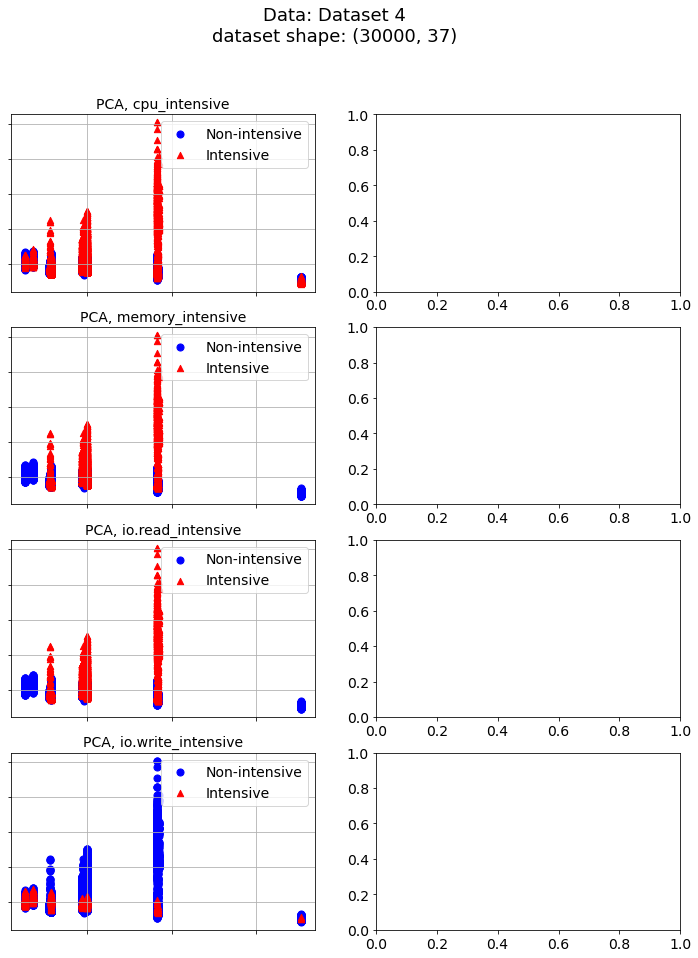

In [32]:
from sklearn.decomposition import SparsePCA
from sklearn.random_projection import SparseRandomProjection

colors = ['b', 'r']


for i, (key, data) in enumerate(datasets_prepared.items()):
    # (fig, subplots) = plt.subplots(5, 2, figsize=(12, 15))
    (fig, subplots) = plt.subplots(4, 2, figsize=(12, 15))

    # PCA
    pca = PCA(n_components=2)
    # pca = PCA(n_components=2, svd_solver='randomized', whiten=True)
    # pca = SparsePCA(n_components=2)
    # pca = SparseRandomProjection(n_components=2)
    principalComponentsPCA = pca.fit_transform(data["features"])
    # pca.explained_variance_ratio_
    principalDfPCA = pd.DataFrame(data = principalComponentsPCA, columns = ['pc1', 'pc2'])

    fig.suptitle(f'Data: {key}\ndataset shape: {data["data"].shape}', fontsize=18)
    for j, label in enumerate(data["labels_classify"].columns):
        finalDf = pd.concat([principalDfPCA, data["labels_classify"][label]], axis = 1)
        ax = subplots[j][0]
        ax.set_title(f"PCA, {label}", fontsize = 14)
        targets = [0,1]
        for target, color in zip(targets,colors):
            indicesToKeep = finalDf[label] == target
            if target == 0:
                ax.scatter(finalDf.loc[indicesToKeep, 'pc1'], finalDf.loc[indicesToKeep, 'pc2'], c = color, s = 50, marker="o")
            else:
                ax.scatter(finalDf.loc[indicesToKeep, 'pc1'], finalDf.loc[indicesToKeep, 'pc2'], c = color, s = 40, marker="^")
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        # ax.legend(targets)
        ax.legend(["Non-intensive", "Intensive"])
        ax.grid()

    # t-SNE
    tsne = manifold.TSNE(n_components=2, init='random', random_state=0, perplexity=35, n_iter=2500)
    principalComponentsTSNE = tsne.fit_transform(data["features"])
    principalDfTSNE = pd.DataFrame(data = principalComponentsTSNE, columns = ['pc1', 'pc2'])

    for j, label in enumerate(data["labels_classify"].columns):
        finalDf = pd.concat([principalDfTSNE, data["labels_classify"][label]], axis = 1)
        ax = subplots[j][1]
        ax.set_title(f"t-SNE, {label}", fontsize = 14)
        targets = [0,1]
        for target, color in zip(targets,colors):
            indicesToKeep = finalDf[label] == target
            if target == 0:
                ax.scatter(finalDf.loc[indicesToKeep, 'pc1'], finalDf.loc[indicesToKeep, 'pc2'], c = color, s = 50, marker="o")
            else:
                ax.scatter(finalDf.loc[indicesToKeep, 'pc1'], finalDf.loc[indicesToKeep, 'pc2'], c = color, s = 30, marker="^")
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.yaxis.set_major_formatter(NullFormatter())
        ax.legend(["Non-intensive", "Intensive"])
        ax.grid()

    fig.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.plot()
    plt.show()

## [LR] Classify jobs based on intensivity 

In [33]:
models = {}
for key, data_dict in datasets_prepared.items():
    desc = descriptions[key]
    print(f'### {desc} - {data_dict["features"].shape}\n')
    models[key] = apply_classifiers(data_dict["features"], data_dict["labels_classify"])

### Evenly distributed data, containing all types of jobs, on all types of machines - (2800, 56)

CPU_INTENSIVE prediction:
score = 0.9042857142857142
F1 = 0.9024745269286754

[[323  17]
 [ 50 310]]
(array([0.86595174, 0.94801223]), array([0.95      , 0.86111111]), array([0.90603086, 0.90247453]), array([340, 360]))
MEMORY_INTENSIVE prediction:
score = 0.9714285714285714
F1 = 0.9530516431924883

[[477  13]
 [  7 203]]
(array([0.98553719, 0.93981481]), array([0.97346939, 0.96666667]), array([0.97946612, 0.95305164]), array([490, 210]))
IO.READ_INTENSIVE prediction:
score = 0.9928571428571429
F1 = 0.9851632047477744

[[529   5]
 [  0 166]]
(array([1.        , 0.97076023]), array([0.9906367, 1.       ]), array([0.99529633, 0.9851632 ]), array([534, 166]))
IO.WRITE_INTENSIVE prediction:
score = 1.0
F1 = 1.0

[[606   0]
 [  0  94]]
(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([606,  94]))
### Jobs of execution time lower than 3 s - (2160, 46)

CPU_INTENSIVE prediction:
score = 

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


IO.WRITE_INTENSIVE prediction:
score = 1.0
F1 = 1.0

[[554   0]
 [  0 103]]
(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([554, 103]))
### Only most occurring jobs, with occurrence greater than 3000 - (30000, 33)

CPU_INTENSIVE prediction:
score = 0.9924
F1 = 0.9904185577407967

[[4497   55]
 [   2 2946]]
(array([0.99955546, 0.98167278]), array([0.9879174 , 0.99932157]), array([0.99370235, 0.99041856]), array([4552, 2948]))
MEMORY_INTENSIVE prediction:
score = 1.0
F1 = 1.0

[[6033    0]
 [   0 1467]]
(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([6033, 1467]))
IO.READ_INTENSIVE prediction:
score = 1.0
F1 = 1.0

[[6033    0]
 [   0 1467]]
(array([1., 1.]), array([1., 1.]), array([1., 1.]), array([6033, 1467]))
IO.WRITE_INTENSIVE prediction:
score = 0.9530666666666666
F1 = 0.1889400921658986

[[7107   22]
 [ 330   41]]
(array([0.95562727, 0.65079365]), array([0.99691401, 0.11051213]), array([0.97583413, 0.18894009]), array([7129,  371]))


### Logistic functions of logistic regression models

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:11: MatplotlibDeprecationWarning: Add

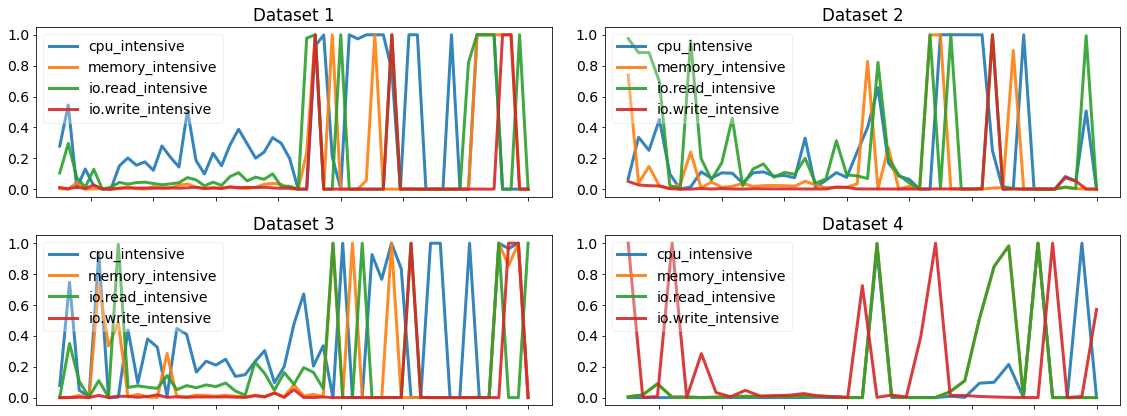

In [34]:
from scipy.special import expit
# fig, axs = plt.subplots(2, 2, constrained_layout=True, figsize=(9,8))
plt.rcParams.update({'font.size': 14})
fig = plt.figure(figsize=(16,6))
i  = 1
for (key, models_dict), (dataset_no, data) in zip(models.items(), datasets_prepared.items()):
    # j = 0
    for resource, clf in models_dict.items():
        X_test = np.linspace(-5, 10, data["features"].shape[1])
        loss = expit(X_test * clf.coef_ + clf.intercept_).ravel()
        ax = plt.subplot(2, 2, i)
        ax.plot(X_test, loss, linewidth=3, label=resource, alpha=0.9)
        ax.set_title(key)
        ax.xaxis.set_major_formatter(NullFormatter())
        ax.legend(loc="upper left", framealpha=0.3)
        # j = j + 1
    i = i + 1
    

plt.tight_layout()
plt.show()

## Train and predict job execution time

In [35]:
results_exec_time = defaultdict(dict)

### Random Forest

In [36]:
for key, data in datasets_prepared.items():
    print(f'\n\n### {key} - {data["data"].shape}\n')
    model = RandomForestRegressor()
    features_train, features_test, labels_train, labels_test = data["split"]
    model.fit(features_train, labels_train)
    predictions = model.predict(features_test[:4])

    # print_full(np.array(labels_test))
    # print_full(model.predict(features_test))

    mase = MASE(labels_train, labels_test, model.predict(features_test))
    mase_fixed = MASE_fixed(labels_test, model.predict(features_test))

    score = model.score(features_test, labels_test)
    mape = mean_absolute_percentage_error(labels_test, model.predict(features_test))
    rae = relative_absolute_error(labels_test, model.predict(features_test))
    print("RAE =", rae)
    print("Mape =", mape)
    print("Mase =", mase)
    print("Mase fixed =", mase_fixed)
    print(f"R^2 Score = {score}")
    adjr2 = adj_R2(score, data["data"].shape[0], model.n_features_)
    print(f"Adj. R^2 Score = {adjr2}")
    for prediction, real in list(zip(predictions.reshape(1,-1)[0], labels_test[:4].values)):
        print(f"prediction/real:  {prediction} / {real}")

    results_exec_time["RandomForest"][key] = {"MAPE": mape, "R2 Score": score, "MASE": mase, "RAE": rae, "MASEv2": mase_fixed}




### Dataset 1 - (2800, 60)

RAE = 0.03233844327581615
Mape = 31.61434446927418
Mase = 0.026501811123396717
Mase fixed = 0.030174171076940703
R^2 Score = 0.9939419074903136
Adj. R^2 Score = 0.9876559046323065
prediction/real:  9.670610000000012 / 9.55
prediction/real:  6.004269999999998 / 3.512
prediction/real:  1153.74616 / 1202.389
prediction/real:  60.65377000000006 / 62.631


### Dataset 2 - (2160, 50)

RAE = 0.06910462180748031
Mape = 16.505150523476683
Mase = 0.05929160915830256
Mase fixed = 0.05791540123503053
R^2 Score = 0.9836504559471178
Adj. R^2 Score = 0.966799329477504
prediction/real:  2.6813500000000055 / 2.68
prediction/real:  2.9360000000000013 / 2.936
prediction/real:  0.5066500000000002 / 0.622
prediction/real:  2.988999999999999 / 2.989


### Dataset 3 - (2625, 53)

RAE = 0.19483997676812126
Mape = 13.090006898467053
Mase = 0.15213643402829838
Mase fixed = 0.1566557206319181
R^2 Score = 0.8611924852592926
Adj. R^2 Score = 0.7363267799511513
prediction/real:  9.8672

### kNN

In [37]:
# for key, data in datasets_prepared.items():
#     print(f'\n\n### {key} - {data["data"].shape}\n')
#     model = KNeighborsRegressor(n_neighbors=10)
#     features_train, features_test, labels_train, labels_test = data["split"]
#     model.fit(features_train, labels_train)
#     predictions = model.predict(features_test[:4])
    
#     score = model.score(features_test, labels_test)
#     print("Mape =", mean_absolute_percentage_error(model.predict(features_test), labels_test))
#     print(f"R^2 Score = {score}")
#     for prediction, real in list(zip(predictions.reshape(1,-1)[0], labels_test[:4].values)):
#         print(f"prediction/real:  {prediction} / {real}")


In [38]:
for key, data in datasets_prepared.items():
    print(f'\n\n### {key} - {data["data"].shape}\n')
    model = KNeighborsRegressor(n_neighbors=10, weights="distance")
    features_train, features_test, labels_train, labels_test = data["split"]
    model.fit(features_train, labels_train)
    predictions = model.predict(features_test[:4])
    mase = MASE(labels_train, labels_test, model.predict(features_test))
    mase_fixed = MASE_fixed(labels_test, model.predict(features_test))
    score = model.score(features_test, labels_test)
    mape = mean_absolute_percentage_error(labels_test, model.predict(features_test))
    rae = relative_absolute_error(labels_test, model.predict(features_test))
    print("RAE =", rae)
    print("Mape =", mape)
    print("Mase =", mase)
    print(f"R^2 Score = {score}")
    for prediction, real in list(zip(predictions.reshape(1,-1)[0], labels_test[:4].values)):
        print(f"prediction/real:  {prediction} / {real}")

    results_exec_time["kNN"][key] = {"MAPE": mape, "R2 Score": score, "MASE": mase, "RAE": rae, "MASEv2": mase_fixed}



### Dataset 1 - (2800, 60)

RAE = 0.02238194165348618
Mape = 46.43773011336836
Mase = 0.018342317384187883
R^2 Score = 0.9953712391017442
prediction/real:  9.68839557899669 / 9.55
prediction/real:  9.344711186044737 / 3.512
prediction/real:  1102.363445752337 / 1202.389
prediction/real:  62.631 / 62.631


### Dataset 2 - (2160, 50)

RAE = 0.06958104498651435
Mape = 16.736748099140467
Mase = 0.0597003791679836
R^2 Score = 0.9734053152676805
prediction/real:  2.2365167989042862 / 2.68
prediction/real:  2.936 / 2.936
prediction/real:  0.5011505548056282 / 0.622
prediction/real:  2.989 / 2.989


### Dataset 3 - (2625, 53)

RAE = 0.16398064734994833
Mape = 10.21941754065646
Mase = 0.12804061749177384
R^2 Score = 0.8748751821950087
prediction/real:  9.585198353034256 / 10.062
prediction/real:  9.522665563933712 / 7.784
prediction/real:  24.982 / 24.982
prediction/real:  9.54 / 9.54


### Dataset 4 - (30000, 37)

RAE = 0.10758504328753651
Mape = 33.299518444575384
Mase = 0.08762896666871928

### GradientBoostingRegressor

In [39]:


for key, data in datasets_prepared.items():
    print(f'\n\n### {key} - {data["data"].shape}\n')

    model = GradientBoostingRegressor(random_state=0, learning_rate=0.4, loss="lad")
    
    features_train, features_test, labels_train, labels_test = data["split"]
    model.fit(features_train, labels_train)
    predictions = model.predict(features_test[:4])

    mase = MASE(labels_train, labels_test, model.predict(features_test))
    score = model.score(features_test, labels_test)
    mape = mean_absolute_percentage_error(labels_test, model.predict(features_test))
    mase_fixed = MASE_fixed(labels_test, model.predict(features_test))
    rae = relative_absolute_error(labels_test, model.predict(features_test))
    print("RAE =", rae)
    print("Mape =", mape)
    print("Mase =", mase)
    print(f"R^2 Score = {score}")
    adjr2 = adj_R2(score, data["data"].shape[0], model.n_features_)
    print(f"Adj. R^2 Score = {adjr2}")
    for prediction, real in list(zip(predictions.reshape(1,-1)[0], labels_test[:4].values)):
        print(f"prediction/real:  {prediction} / {real}")

    results_exec_time["GradientBoosting"][key] = {"MAPE": mape, "R2 Score": score, "MASE": mase, "RAE": rae, "MASEv2": mase_fixed}




### Dataset 1 - (2800, 60)

RAE = 0.1036749439705197
Mape = 630.9736815053537
Mase = 0.08496308124362252
R^2 Score = 0.9773567916015
Adj. R^2 Score = 0.9542454941046837
prediction/real:  10.316346572847493 / 9.55
prediction/real:  7.636796584496804 / 3.512
prediction/real:  1118.978850582754 / 1202.389
prediction/real:  64.42628114789093 / 62.631


### Dataset 2 - (2160, 50)

RAE = 0.15488070134068646
Mape = 33.91909765752391
Mase = 0.13288729132530686
R^2 Score = 0.9259495694806212
Adj. R^2 Score = 0.8540014436571313
prediction/real:  2.7376049860645386 / 2.68
prediction/real:  2.9359999999999995 / 2.936
prediction/real:  0.5160762184148392 / 0.622
prediction/real:  2.9699999999999998 / 2.989


### Dataset 3 - (2625, 53)

RAE = 0.34279082600085586
Mape = 20.499401390161413
Mase = 0.2676605425151019
R^2 Score = 0.7515233744620212
Adj. R^2 Score = 0.5558156714585545
prediction/real:  8.553358361774919 / 10.062
prediction/real:  5.542196474383119 / 7.784
prediction/real:  21.7159999999

### DecisionTreeRegressor

In [40]:
from sklearn.tree import DecisionTreeRegressor

for key, data in datasets_prepared.items():
    print(f'\n\n### {key} - {data["data"].shape}\n')

    model = DecisionTreeRegressor()
    
    features_train, features_test, labels_train, labels_test = data["split"]
    model.fit(features_train, labels_train)
    predictions = model.predict(features_test[:4])

    mase = MASE(labels_train, labels_test, model.predict(features_test))
    mase_fixed = MASE_fixed(labels_test, model.predict(features_test))
    score = model.score(features_test, labels_test)
    mape = mean_absolute_percentage_error(labels_test, model.predict(features_test))
    rae = relative_absolute_error(labels_test, model.predict(features_test))
    print("RAE =", rae)
    print("Mape =", mape)
    print("Mase =", mase)
    print(f"R^2 Score = {score}")
    adjr2 = adj_R2(score, data["data"].shape[0], model.n_features_)
    print(f"Adj. R^2 Score = {adjr2}")
    for prediction, real in list(zip(predictions.reshape(1,-1)[0], labels_test[:4].values)):
        print(f"prediction/real:  {prediction} / {real}")

    results_exec_time["DecisionTree"][key] = {"MAPE": mape, "R2 Score": score, "MASE": mase, "RAE": rae, "MASEv2": mase_fixed}



### Dataset 1 - (2800, 60)

RAE = 0.019110576357180924
Mape = 52.39323084148392
Mase = 0.015661387307904583
R^2 Score = 0.9947816026431697
Adj. R^2 Score = 0.9893624070987659
prediction/real:  9.686 / 9.55
prediction/real:  3.015 / 3.512
prediction/real:  1256.538 / 1202.389
prediction/real:  62.631 / 62.631


### Dataset 2 - (2160, 50)

RAE = 0.06289821998809456
Mape = 14.507207313332202
Mase = 0.05396653043955088
R^2 Score = 0.9791992654619593
Adj. R^2 Score = 0.9578551749634892
prediction/real:  2.7230000000000003 / 2.68
prediction/real:  2.9360000000000053 / 2.936
prediction/real:  0.527 / 0.622
prediction/real:  2.989000000000001 / 2.989


### Dataset 3 - (2625, 53)

RAE = 0.20163413926595836
Mape = 12.737848196233656
Mase = 0.15744150371561338
R^2 Score = 0.8083770241523487
Adj. R^2 Score = 0.6463299246120249
prediction/real:  9.686 / 10.062
prediction/real:  9.52 / 7.784
prediction/real:  24.981999999999985 / 24.982
prediction/real:  9.54 / 9.54


### Dataset 4 - (30000, 37)



### Neural Network Model using MSE as loss func

In [41]:
def build_model(X_train):
    model = tf.keras.Sequential([
        
    tf.keras.layers.Dense(50, activation='relu', input_shape=[len(X_train.keys())]),
    tf.keras.layers.Dropout(0.5, input_shape=(len(X_train.keys()),)),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dropout(0.5, input_shape=(len(X_train.keys()),)),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1)
    ])

    # optimizer = tf.keras.optimizers.SGD(0.001)
    model.compile(loss='mean_squared_error', 
                  optimizer='adam', 
                  metrics=[ 
                            'mean_absolute_error', 
                            'mean_squared_error',
                            tf.keras.metrics.MeanAbsolutePercentageError()
                  ])
    return model

class PrintDot(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: print('')
        print('.', end='')

def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [ReportTime]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
#     plt.ylim([0,20])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$ReportTime^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
#     plt.ylim([0,50])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('mean_absolute_percentage_error')
    plt.plot(hist['epoch'], hist['mean_absolute_percentage_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_percentage_error'],
           label = 'Val Error')
#     plt.ylim([0,50])
    plt.legend()
    plt.show()

In [42]:
def train_nn(data_final, features_train, features_test, labels_train, labels_test):
    model = build_model(data_final)
    EPOCHS = 200

    # Using 20% of data for training validation
    history = model.fit(features_train, labels_train,
                        epochs=EPOCHS, validation_split = 0.2, batch_size=30, verbose=0,
                        callbacks=[PrintDot()])

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist.tail()

    plot_history(history)
    metrics = model.evaluate(features_test , labels_test, verbose=0)

    for name, value in list(zip(model.metrics_names, metrics)):
        print(f"{name}: {value}")
    predictions = model.predict(features_test[:4])
    with pd.option_context('display.float_format', '{:0.2f}'.format):
    # predictions
    # print("predictions:\n", scale_labels_mm.inverse_transform(predictions))
    # print("real values:\n", scale_labels_mm.inverse_transform(labels_test[:4]))

        # print("predictions:\n", pd.DataFrame(predictions))
        # print("real values:\n", labels_test[:4])
        for prediction, real in list(zip(predictions.reshape(1,-1)[0], labels_test[:4].values)):
            print(f"prediction/real:  {prediction} / {real}")

In [43]:
# for key, data in datasets_prepared.items():
#     print(f'\n\n### {key} - {data["data"].shape}\n')
#     train_nn(data["data"], *data["split"])

### Neural Network using MAPE as loss func



### Dataset 1 - (2800, 60)


....................................................................................................
....................................................................................................

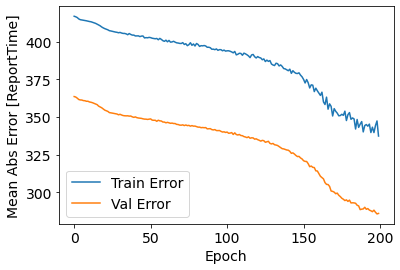

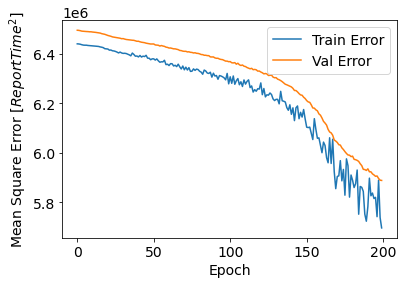

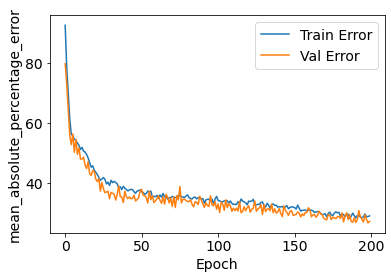

RAE = 0.44347860623689045
loss: 26.118337631225586
mean_absolute_error: 284.5743408203125
mean_squared_error: 4177447.75
mean_absolute_percentage_error: 26.118337631225586
MASE: 0.3634369830209669
prediction/real:  7.843405723571777 / 9.55
prediction/real:  4.933614730834961 / 3.512
prediction/real:  975.830810546875 / 1202.389
prediction/real:  43.87393569946289 / 62.631


### Dataset 2 - (2160, 50)


....................................................................................................
....................................................................................................

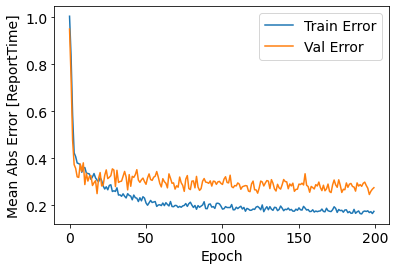

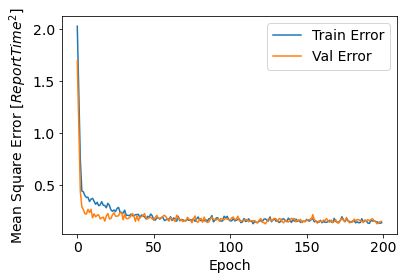

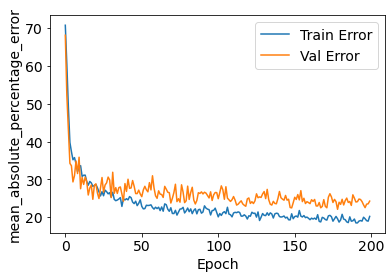

RAE = 0.24682761232836112
loss: 20.71699333190918
mean_absolute_error: 0.24758309125900269
mean_squared_error: 0.12798601388931274
mean_absolute_percentage_error: 20.71699333190918
MASE: 0.21177753291844315
prediction/real:  1.8884685039520264 / 2.68
prediction/real:  2.4919052124023438 / 2.936
prediction/real:  0.5004770159721375 / 0.622
prediction/real:  2.546103000640869 / 2.989


### Dataset 3 - (2625, 53)


....................................................................................................
....................................................................................................

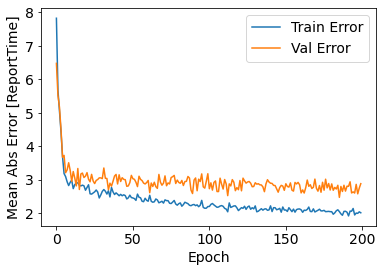

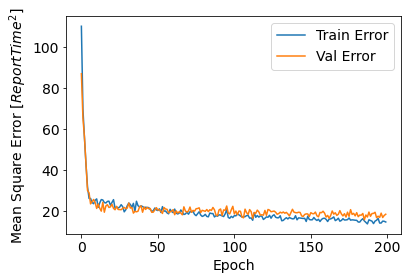

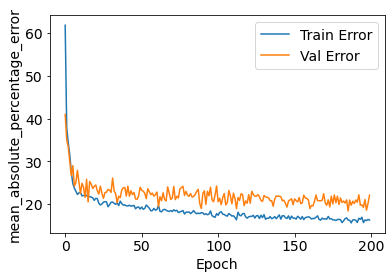

RAE = 0.4654066917913533
loss: 22.79364013671875
mean_absolute_error: 2.8616931438446045
mean_squared_error: 18.992237091064453
mean_absolute_percentage_error: 22.79364013671875
MASE: 0.36340239634861493
prediction/real:  7.977002143859863 / 10.062
prediction/real:  5.986300468444824 / 7.784
prediction/real:  20.141706466674805 / 24.982
prediction/real:  5.468195915222168 / 9.54


### Dataset 4 - (30000, 37)


....................................................................................................
....................................................................................................

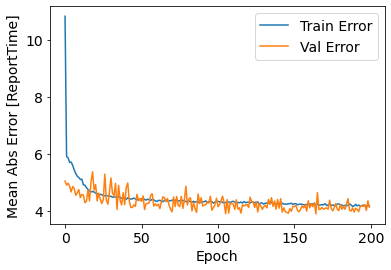

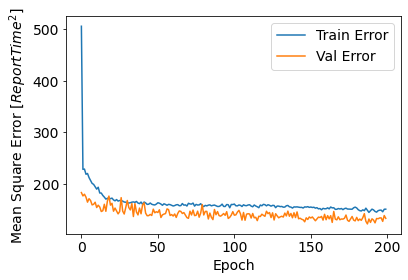

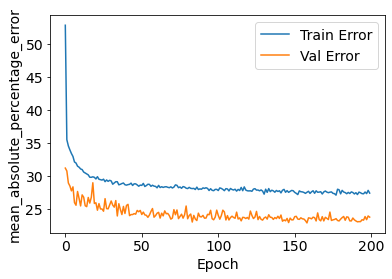

RAE = 0.2212803891948365
loss: 24.006338119506836
mean_absolute_error: 4.130920886993408
mean_squared_error: 137.672119140625
mean_absolute_percentage_error: 24.006338119506836
MASE: 0.18023482871472565
prediction/real:  0.5594533085823059 / 1.247
prediction/real:  0.09096129983663559 / 0.05
prediction/real:  0.12516549229621887 / 1.933
prediction/real:  0.6977327466011047 / 0.79


In [44]:
def build_model(X_train):
    model = tf.keras.Sequential([
    tf.keras.layers.Dropout(0.2, input_shape=(len(X_train.keys()),)),
    tf.keras.layers.Dense(50, activation='relu', input_shape=[len(X_train.keys())]),
    tf.keras.layers.Dense(50, activation='relu'),
    tf.keras.layers.Dense(25, activation='relu'),
    tf.keras.layers.Dense(1)
    ])

    model.compile(loss='mean_absolute_percentage_error', 
                  optimizer='adam', 
                  metrics=['mean_absolute_error', 
                           'mean_squared_error', 
                           tf.keras.metrics.MeanAbsolutePercentageError(),
                        #   tf.keras.metrics.MeanRelativeError()
                           ])
    return model

def train_nn(data_final, features_train, features_test, labels_train, labels_test):
    model = build_model(data_final)
    EPOCHS = 200

    # Using 20% of data for training validation
    history = model.fit(features_train, labels_train,
                        epochs=EPOCHS, validation_split = 0.2, batch_size=30, verbose=0,
                        callbacks=[PrintDot()])

    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch
    hist.tail()

    plot_history(history)
    metrics = model.evaluate(features_test , labels_test, verbose=0)
    res = {}
    mase = MASE(labels_train, labels_test, model.predict(features_test).reshape(1,-1)[0])
    mase_fixed = MASE_fixed(labels_test, model.predict(features_test).reshape(1,-1)[0])
    r2 = r2_score(labels_test, model.predict(features_test).reshape(1,-1)[0])
    rae = relative_absolute_error(labels_test, model.predict(features_test).reshape(1,-1)[0])
    print("RAE =", rae)
    res["RAE"] = rae
    res["MASE"] = mase
    res["R2 Score"] = r2
    res["MASEv2"] = mase_fixed
    for name, value in list(zip(model.metrics_names, metrics)):
        print(f"{name}: {value}")
        res[name] = value
    print("MASE:", mase)
    predictions = model.predict(features_test[:4])
    with pd.option_context('display.float_format', '{:0.2f}'.format):
        for prediction, real in list(zip(predictions.reshape(1,-1)[0], labels_test[:4].values)):
            print(f"prediction/real:  {prediction} / {real}")
    
    return res

for key, data in datasets_prepared.items():
    print(f'\n\n### {key} - {data["data"].shape}\n')
    metrics = train_nn(data["data"], *data["split"])
    metrics["MAPE"] = metrics["mean_absolute_percentage_error"]
    metrics.pop('mean_absolute_percentage_error', None)

    results_exec_time["Neural Network"][key] = metrics

In [45]:
print(f"Time elapsed: {(time.time() - start_time)/60} min")

Time elapsed: 26.727208805084228 min


In [46]:
results_df = pd.DataFrame.from_dict({(i,j): results_exec_time[i][j] 
                           for i in results_exec_time.keys() 
                           for j in results_exec_time[i].keys()},
                           orient='index')
print_full(results_df)
old_cols = results_df.columns
new_cols = ['Technique', 'Dataset'] + list(old_cols)
results_df.reset_index(inplace=True)
results_df.columns = new_cols
results_df.sort_values(by=["Dataset", "MAPE"])

MAPE  R2 Score  MASE  RAE  MASEv2  loss  \
RandomForest     Dataset 1  31.61      0.99  0.03 0.03    0.03   nan   
                 Dataset 2  16.51      0.98  0.06 0.07    0.06   nan   
                 Dataset 3  13.09      0.86  0.15 0.19    0.16   nan   
                 Dataset 4  37.73      0.95  0.10 0.13    0.10   nan   
kNN              Dataset 1  46.44      1.00  0.02 0.02    0.02   nan   
                 Dataset 2  16.74      0.97  0.06 0.07    0.06   nan   
                 Dataset 3  10.22      0.87  0.13 0.16    0.13   nan   
                 Dataset 4  33.30      0.96  0.09 0.11    0.09   nan   
GradientBoosting Dataset 1 630.97      0.98  0.08 0.10    0.10   nan   
                 Dataset 2  33.92      0.93  0.13 0.15    0.13   nan   
                 Dataset 3  20.50      0.75  0.27 0.34    0.28   nan   
                 Dataset 4  36.45      0.94  0.12 0.15    0.12   nan   
DecisionTree     Dataset 1  52.39      0.99  0.02 0.02    0.02   nan   
                 Dataset 2  14.51      0.98  0.05 0.06    0.05   nan   
                 Dataset 3  12.74      0.81  0.16 0.20    0.16   nan   
                 Dataset 4  36.81      0.93  0.11 0.13    0.11   nan   
Neural Network   Dataset 1  26.12      0.10  0.36 0.44    0.41 26.12   
                 Dataset 2  20.72      0.89  0.21 0.25    0.21 20.72   
                 Dataset 3  22.79      0.62  0.36 0.47    0.37 22.79   
                 Dataset 4  24.01      0.76  0.18 0.22    0.18 24.01   

                            mean_absolute_error  mean_squared_error  
RandomForest     Dataset 1                  nan                 nan  
                 Dataset 2                  nan                 nan  
                 Dataset 3                  nan                 nan  
                 Dataset 4                  nan                 nan  
kNN              Dataset 1                  nan                 nan  
                 Dataset 2                  nan                 nan  
                 Dataset 3                  nan                 nan  
                 Dataset 4                  nan                 nan  
GradientBoosting Dataset 1                  nan                 nan  
                 Dataset 2                  nan                 nan  
                 Dataset 3                  nan                 nan  
                 Dataset 4                  nan                 nan  
DecisionTree     Dataset 1                  nan                 nan  
                 Dataset 2                  nan                 nan  
                 Dataset 3                  nan                 nan  
                 Dataset 4                  nan                 nan  
Neural Network   Dataset 1               284.57        4,177,447.75  
                 Dataset 2                 0.25                0.13  
                 Dataset 3                 2.86               18.99  
                 Dataset 4                 4.13              137.67

,Technique,Dataset,MAPE,R2 Score,MASE,RAE,MASEv2,loss,mean_absolute_error,mean_squared_error
16,Neural Network,Dataset 1,26.12,0.10,0.36,0.44,0.41,26.12,284.57,"4,177,447.75"
0,RandomForest,Dataset 1,31.61,0.99,0.03,0.03,0.03,nan,nan,nan
4,kNN,Dataset 1,46.44,1.00,0.02,0.02,0.02,nan,nan,nan
12,DecisionTree,Dataset 1,52.39,0.99,0.02,0.02,0.02,nan,nan,nan
8,GradientBoosting,Dataset 1,630.97,0.98,0.08,0.10,0.10,nan,nan,nan
13,DecisionTree,Dataset 2,14.51,0.98,0.05,0.06,0.05,nan,nan,nan
1,RandomForest,Dataset 2,16.51,0.98,0.06,0.07,0.06,nan,nan,nan
5,kNN,Dataset 2,16.74,0.97,0.06,0.07,0.06,nan,nan,nan
17,Neural Network,Dataset 2,20.72,0.89,0.21,0.25,0.21,20.72,0.25,0.13
9,GradientBoosting,Dataset 2,33.92,0.93,0.13,0.15,0.13,nan,nan,nan
